# **RAG + RAGAS**

In [101]:
import pkg_resources

for dist in sorted(pkg_resources.working_set, key=lambda d: d.project_name.lower()):
    print(f"{dist.project_name}=={dist.version}")


C:\Users\AZhaa\AppData\Local\Temp\ipykernel_8160\102525389.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


accelerate==1.12.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aioitertools==0.13.0
aiosignal==1.4.0
aiosqlite==0.21.0
alembic==1.17.2
annotated-doc==0.0.4
annotated-types==0.7.0
anyio==4.11.0
appdirs==1.4.4
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
arize-phoenix==12.16.0
arize-phoenix-client==1.24.0
arize-phoenix-evals==2.6.0
arize-phoenix-otel==0.14.0
arrow==1.4.0
asttokens==3.0.1
async-lru==2.0.5
async-timeout==4.0.3
attrs==25.4.0
authlib==1.6.5
autocommand==2.2.2
babel==2.17.0
backoff==2.2.1
backports.tarfile==1.2.0
banks==2.2.0
bcrypt==5.0.0
beautifulsoup4==4.14.2
bleach==6.3.0
brotlicffi==1.1.0.0
build==1.3.0
cachetools==6.2.2
certifi==2025.11.12
cffi==2.0.0
cfgv==3.5.0
charset-normalizer==3.4.4
chromadb==1.3.7
click==8.3.1
colorama==0.4.6
coloredlogs==15.0.1
comm==0.2.3
contourpy==1.3.2
cryptography==46.0.3
cycler==0.12.1
dataclasses-json==0.6.7
datasets==4.4.1
debugpy==1.8.17
decorator==5.2.1
defusedxml==0.7.1
Deprecated==1.2.18
dill==0.4.0
dirtyjson==1.0.8
diskcache==5.6.3


In [1]:
import json
from pathlib import Path
from typing import List, Dict
import pandas as pd

BASE_DIR = Path("arabicaqa_rag_results/dataset")

# Optional: simple cleaner
def clean_text(text: str) -> str:
    if text is None:
        return ""
    return str(text).strip()

def flatten_qa_split(json_path: Path, split_name: str) -> pd.DataFrame:
    """
    Load one QA JSON file (MRC or Open-Domain with context)
    and flatten it into a DataFrame.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    records: List[Dict] = []

    for article in raw["data"]:
        for para in article["paragraphs"]:
            context = clean_text(para.get("context", ""))
            document_id = para.get("document_id")

            for qa in para["qas"]:
                question = clean_text(qa.get("question", ""))
                # base is_impossible flag (from file if present)
                is_impossible = bool(qa.get("is_impossible", False))

                answers_list = qa.get("answers", [])
                answer_texts = [clean_text(a.get("text", "")) for a in answers_list]

                # ---- NEW LOGIC: '.' = unanswerable ----
                # if the only answer is "." → treat as unanswerable
                has_only_dot = (
                    len(answer_texts) > 0
                    and all(ans == "." for ans in answer_texts)
                )

                if has_only_dot:
                    is_impossible = True
                    # Usually for unanswerable we keep answers empty
                    answer_texts = []

                # Also: if there are no answers at all, mark as impossible
                if len(answer_texts) == 0:
                    is_impossible = True

                records.append(
                    {
                        "split": split_name,       # train / validation / test
                        "document_id": document_id,
                        "question_id": qa.get("id"),
                        "question": question,
                        "context": context,
                        "answers": answer_texts,   # list of strings
                        "is_impossible": is_impossible,
                    }
                )

    return pd.DataFrame(records)

# ---- Build all three MRC splits ----
df_train_mrc = flatten_qa_split(BASE_DIR / "MRC" / "train.json", "train")
df_val_mrc   = flatten_qa_split(BASE_DIR / "MRC" / "validation.json", "validation")
df_test_mrc  = flatten_qa_split(BASE_DIR / "MRC" / "test.json", "test")

# (Optional) If Open-Domain uses the same structure & has context now:
# df_train_open = flatten_qa_split(BASE_DIR / "Open-Domain" / "train.json", "train")
# df_val_open   = flatten_qa_split(BASE_DIR / "Open-Domain" / "validation.json", "validation")
# df_test_open  = flatten_qa_split(BASE_DIR / "Open-Domain" / "test.json", "test")

# ---- Merge MRC into one DataFrame ----
df_all_mrc = pd.concat([df_train_mrc, df_val_mrc, df_test_mrc], ignore_index=True)

df_all_mrc.head()


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1338857,645198,ما هو عدد المقاطعات في إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[15],False
1,train,1338857,645409,ما هي أكبر طائفة مسيحية في إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[الكنيسة الإنجيلية اللوثرية الإستونية],False
2,train,1338857,645410,كم عدد المسلمين في إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[المسلمين يتجاوز عددهم 10000],False
3,train,1338857,645203,ما هو عدد سكان إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,"[1,319,133مليون نسمة]",False
4,train,1338857,645202,ما هي عاصمة إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[تالين],False


In [24]:
from pathlib import Path
import pandas as pd
import json

BASE_DIR = Path("arabicaqa_rag_results/dataset")
BASE_DIR.mkdir(parents=True, exist_ok=True)

df_export = df_all_mrc.copy()

list_columns = ["answers"]  # ضع الأعمدة التي تحتوي قوائم

# تحويل القوائم إلى JSON string
for col in list_columns:
    df_export[col] = df_export[col].apply(
        lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, list) else "[]"
    )

df_export.to_csv(BASE_DIR / "df_all_mrc.csv", index=False, encoding="utf-8-sig")

print("✅ df_all_mrc.csv saved")


✅ df_all_mrc.csv saved


In [97]:
import pandas as pd
import json

df_all_mrc = pd.read_csv("arabicaqa_rag_results/dataset/df_all_mrc.csv")

list_columns = ["answers"]

for col in list_columns:
    df_all_mrc[col] = df_all_mrc[col].apply(lambda x: json.loads(x) if isinstance(x, str) else [])


| **Category**            | **Training** | **Validation** | **Test** | **Total**  |
| ----------------------- | ------------ | -------------- | -------- | ---------- |
|<mark> **MRC (with answers)**  | 62,186       | 13,483         | 13,426   | **89,095**|
|<mark> **MRC (unanswerable)**  | 2,596        | 561            | 544      | **3,701**  |
| **Open-Domain**         | 62,057       | 13,475         | 13,414   | **88,946** |
| **Open-Domain (Human)** | 58,676       | 12,715         | 12,592   | **83,983** |

We will take a sample of **MRC (with answers)** and **MRC (unanswerable)** => 500 form each part => Total 1000

In [98]:
df_all_mrc["is_impossible"].value_counts()

is_impossible
False    89095
True      3701
Name: count, dtype: int64

In [99]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ============= 1) Helper functions =============

def word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    return len(str(text).split())

latin_pattern = re.compile(r"[A-Za-z]")

def foreign_word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    tokens = str(text).split()
    return sum(1 for t in tokens if latin_pattern.search(t))


# ============= 2) Compute statistics =============

# Lengths
df_all_mrc["context_word_len"] = df_all_mrc["context"].apply(word_count)
df_all_mrc["question_word_len"] = df_all_mrc["question"].apply(word_count)

# Number of answers
def answers_len_safe(x):
    if isinstance(x, list):
        return len(x)
    return 0

df_all_mrc["n_answers"] = df_all_mrc["answers"].apply(answers_len_safe)

# Answer lengths (flatten all answers)
all_answer_lengths = []
for ans_list in df_all_mrc["answers"]:
    if isinstance(ans_list, list):
        for a in ans_list:
            all_answer_lengths.append(word_count(a))

mean_answer_len = float(np.mean(all_answer_lengths)) if all_answer_lengths else 0.0

# Foreign words in context
df_all_mrc["context_foreign_word_count"] = df_all_mrc["context"].apply(
    foreign_word_count
)

# Means
mean_context_len = df_all_mrc["context_word_len"].mean()
mean_question_len = df_all_mrc["question_word_len"].mean()
mean_n_answers = df_all_mrc["n_answers"].mean()
mean_foreign_per_context = df_all_mrc["context_foreign_word_count"].mean()

print("📊 Dataset stats (MRC):")
print(f"- Mean context length (words):        {mean_context_len:.2f}")
print(f"- Mean question length (words):       {mean_question_len:.2f}")
print(f"- Mean #answers per question:         {mean_n_answers:.2f}")
print(f"- Mean answer length (words, global): {mean_answer_len:.2f}")
print(f"- Mean foreign words per context:     {mean_foreign_per_context:.2f}")

📊 Dataset stats (MRC):
- Mean context length (words):        456.87
- Mean question length (words):       7.71
- Mean #answers per question:         0.96
- Mean answer length (words, global): 8.83
- Mean foreign words per context:     2.20


Saved → arabicaqa_rag_results/ragas_full\figures_full\full_means_bar.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_means_bar.pdf


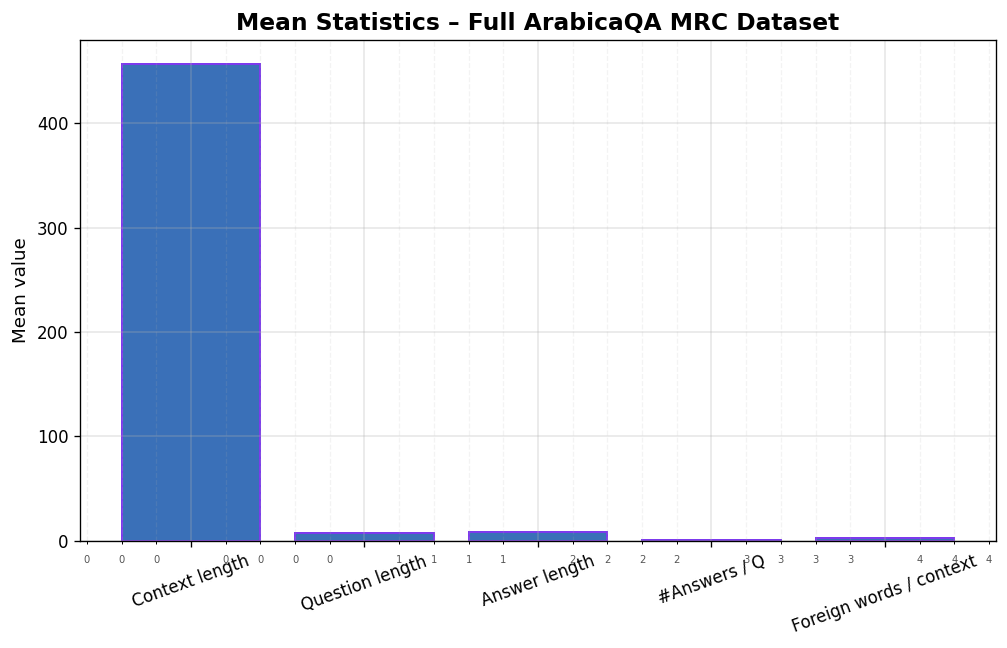

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_context_length.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_context_length.pdf


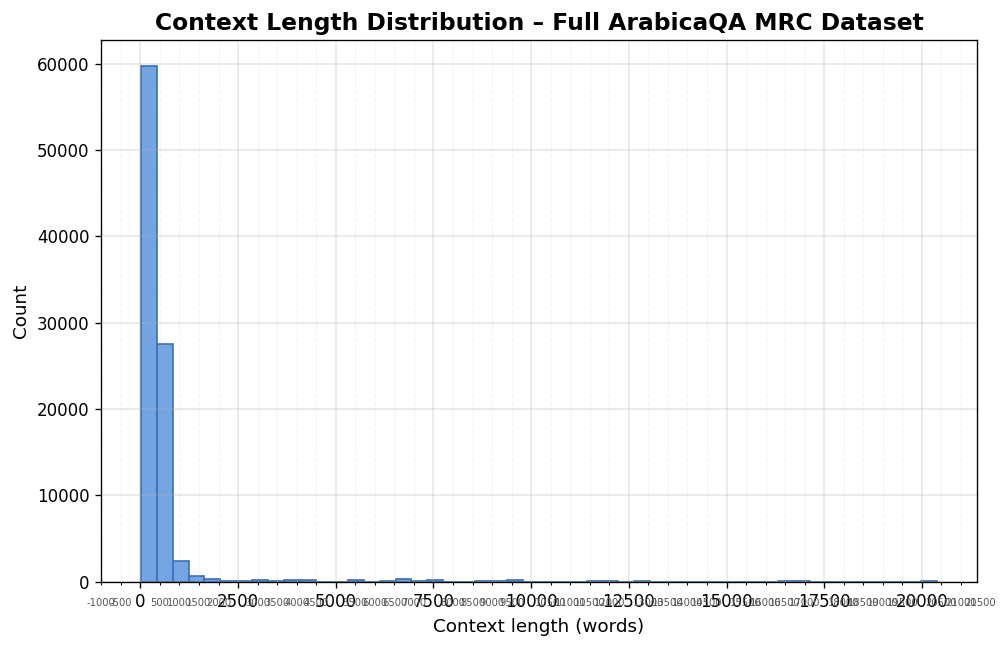

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_question_length.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_question_length.pdf


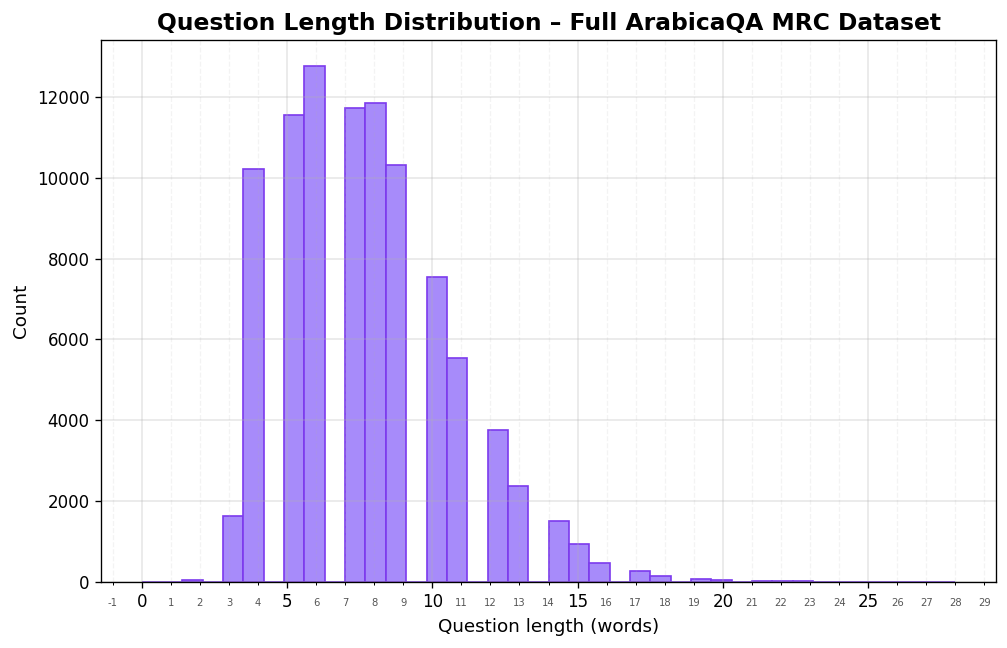

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_answer_length.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_answer_length.pdf


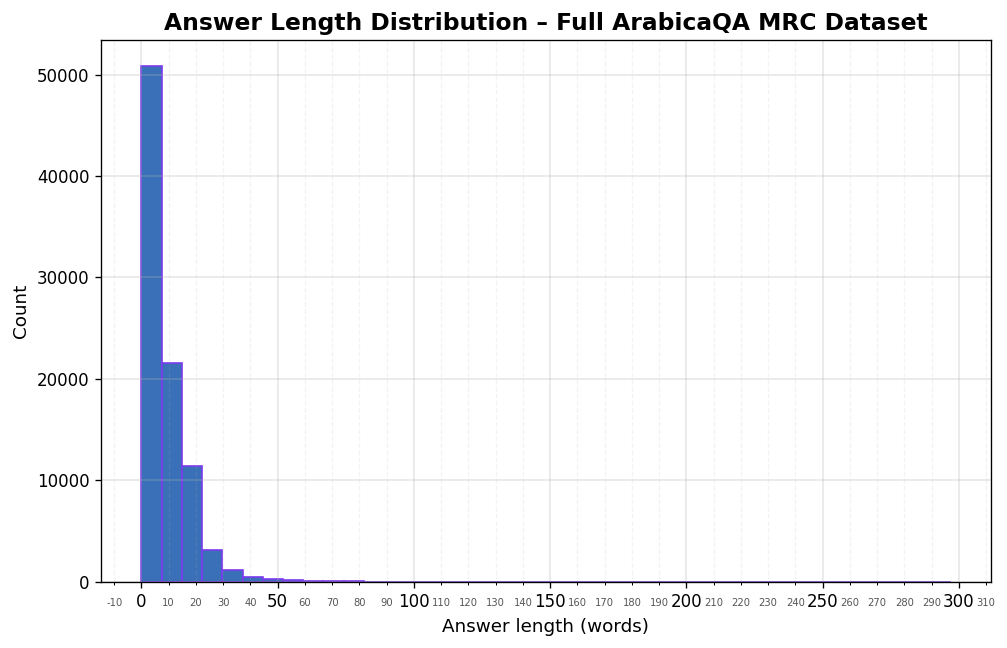

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_foreign_words.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_foreign_words.pdf


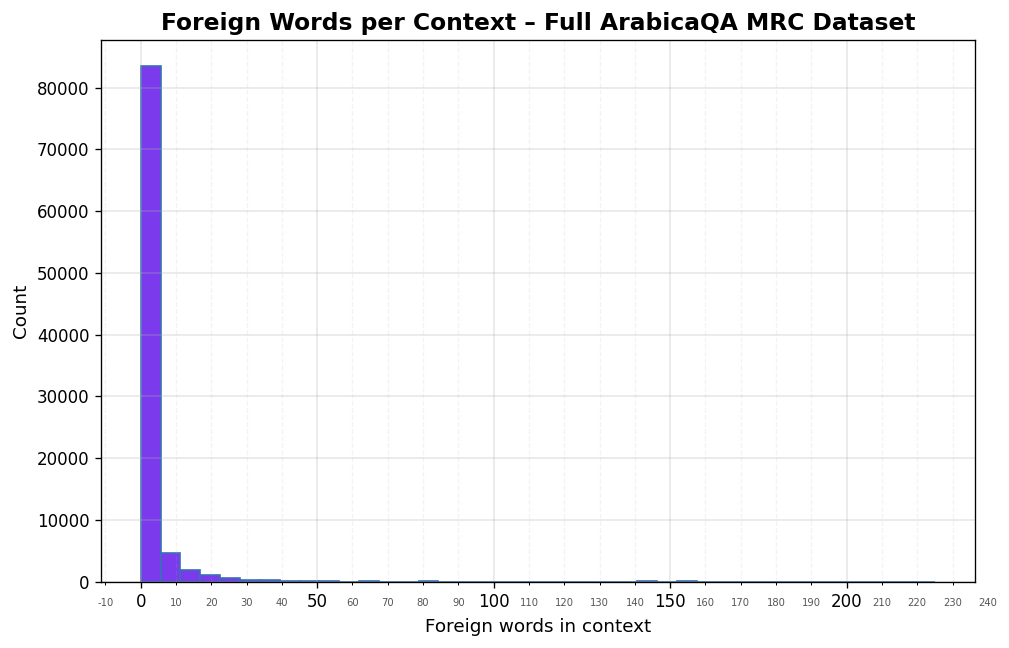

In [100]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# ======================
# PATHS
# ======================
OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures_full")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# THEME
# ======================
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["figure.dpi"] = 120

def apply_style_with_minor_ticks(ax):
    """Apply theme + grid + minor ticks labels"""
    ax.grid(which="major", alpha=0.3, linewidth=1)
    ax.grid(which="minor", alpha=0.15, linestyle="--")

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    minor_ticks = ax.xaxis.get_minorticklocs()
    for tick in minor_ticks:
        ax.text(
            tick,
            -0.045,
            f"{int(tick)}",
            transform=ax.get_xaxis_transform(),
            fontsize=6,
            color="#555",
            ha="center"
        )

    plt.tight_layout()

def save_fig(name_base: str):
    """Save current figure as PNG + PDF."""
    png_path = os.path.join(FIG_DIR, f"{name_base}.png")
    pdf_path = os.path.join(FIG_DIR, f"{name_base}.pdf")
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    print("Saved →", png_path)
    print("Saved →", pdf_path)


# ======================================================
# 3) Bar plot of the means
# ======================================================
labels = [
    "Context length",
    "Question length",
    "Answer length",
    "#Answers / Q",
    "Foreign words / context",
]

values = [
    mean_context_len,
    mean_question_len,
    mean_answer_len,
    mean_n_answers,
    mean_foreign_per_context,
]

fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.bar(labels, values, color=PRIMARY, edgecolor=ACCENT2, linewidth=1.2)
ax.set_ylabel("Mean value")
ax.set_title("Mean Statistics – Full ArabicaQA MRC Dataset", fontsize=14)
ax.tick_params(axis="x", rotation=20)
apply_style_with_minor_ticks(ax)

save_fig("full_means_bar")
plt.show()


# ======================================================
# 4) Histograms for FULL DATA
# ======================================================

# ========= Context length =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_all_mrc["context_word_len"], bins=50, color=SECONDARY, edgecolor=PRIMARY)
ax.set_xlabel("Context length (words)")
ax.set_ylabel("Count")
ax.set_title("Context Length Distribution – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_context_length")
plt.show()


# ========= Question length =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_all_mrc["question_word_len"], bins=40, color=ACCENT1, edgecolor=ACCENT2)
ax.set_xlabel("Question length (words)")
ax.set_ylabel("Count")
ax.set_title("Question Length Distribution – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_question_length")
plt.show()


# ========= Answer length =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(all_answer_lengths, bins=40, color=PRIMARY, edgecolor=ACCENT2)
ax.set_xlabel("Answer length (words)")
ax.set_ylabel("Count")
ax.set_title("Answer Length Distribution – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_answer_length")
plt.show()


# ========= Foreign words per context =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_all_mrc["context_foreign_word_count"], bins=40, color=ACCENT2, edgecolor=PRIMARY)
ax.set_xlabel("Foreign words in context")
ax.set_ylabel("Count")
ax.set_title("Foreign Words per Context – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_foreign_words")
plt.show()


In [43]:
import pandas as pd
import json

# ========== 1) Read dataset ==========
df = pd.read_csv("arabicaqa_rag_results/dataset/df_all_mrc.csv")

# ========== 2) Decode list-like columns stored as JSON strings ==========
list_columns = ["answers"]   # عدّليها لو عندك أعمدة أخرى فيها lists

for col in list_columns:
    df[col] = df[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

# ========== 3) Split dataset into answerable / unanswerable ==========
df_answerable = df[df["is_impossible"] == False]
df_unanswerable = df[df["is_impossible"] == True]

# ========== 4) Sample 500 from each ==========
sample_answerable = df_answerable.sample(500, random_state=42)
sample_unanswerable = df_unanswerable.sample(500, random_state=42)

# ========== 5) Combine into final sample ==========
df_sample = pd.concat([sample_answerable, sample_unanswerable], ignore_index=True)

print("Sample shape:", df_sample.shape)
df_sample.head()


Sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [ ]:
import pandas as pd
import json

# ======================================================
# 1) Load the sample
# ======================================================

df_sample = df_sample.copy()   # تأكدي أن df_sample موجود بالفعل


# ======================================================
# 2) Helper: safe parsing for list-columns (answers)
# ======================================================

def safe_parse_list(x):
    """Return a clean Python list, fixing formatting problems."""
    
    if isinstance(x, list):
        return x
    
    if pd.isna(x):
        return []
    
    s = str(x).strip()
    if s == "":
        return []

    # Try JSON as-is
    try:
        return json.loads(s)
    except:
        pass
    
    # Try JSON with single-quotes replaced
    try:
        s2 = s.replace("'", '"')
        return json.loads(s2)
    except:
        pass
    
    # Fallback: return as single-item list
    return [s]


# ======================================================
# 3) Fix list-columns (answers)
# ======================================================

list_columns = ["answers"]

for col in list_columns:
    df_sample[col] = df_sample[col].apply(safe_parse_list)


# ======================================================
# 4) Clean other text columns: strip whitespace, ensure strings
# ======================================================

text_columns = ["question", "context"]

for col in text_columns:
    df_sample[col] = df_sample[col].fillna("").astype(str).str.strip()


# ======================================================
# 5) Optional safety checks (remove broken rows)
# ======================================================

# Remove empty context/question rows (rare but safe)
df_sample = df_sample[df_sample["question"] != ""]
df_sample = df_sample[df_sample["context"] != ""]

# Ensure is_impossible is boolean
df_sample["is_impossible"] = df_sample["is_impossible"].astype(bool)


# ======================================================
# 6) Save cleaned sample
# ======================================================

output_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"

# Convert lists into JSON before saving
df_to_save = df_sample.copy()
for col in list_columns:
    df_to_save[col] = df_to_save[col].apply(lambda x: json.dumps(x, ensure_ascii=False))

df_to_save.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✨ Sample cleaned and saved to:", output_path)
print("Final shape:", df_sample.shape)


In [89]:
import pandas as pd
import json

# ========== Load sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample_loaded = pd.read_csv(sample_path)

# ========== Fix list columns after loading ==========
list_columns = ["answers"]

for col in list_columns:
    df_sample_loaded[col] = df_sample_loaded[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

print("✨ Loaded sample shape:", df_sample_loaded.shape)
df_sample_loaded.head()


✨ Loaded sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [90]:
import numpy as np
import re

def word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    return len(str(text).split())

latin_pattern = re.compile(r"[A-Za-z]")

def foreign_word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    tokens = str(text).split()
    return sum(1 for t in tokens if latin_pattern.search(t))


# نفس الحساب ولكن على df_sample فقط

df_sample["context_word_len"] = df_sample["context"].apply(word_count)
df_sample["question_word_len"] = df_sample["question"].apply(word_count)

df_sample["n_answers"] = df_sample["answers"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# answer lengths (global)
all_sample_answer_lengths = []
for ans_list in df_sample["answers"]:
    if isinstance(ans_list, list):
        for a in ans_list:
            all_sample_answer_lengths.append(word_count(a))

mean_context_len_s = df_sample["context_word_len"].mean()
mean_question_len_s = df_sample["question_word_len"].mean()
mean_n_answers_s = df_sample["n_answers"].mean()
mean_answer_len_s = np.mean(all_sample_answer_lengths) if all_sample_answer_lengths else 0
df_sample["foreign_words"] = df_sample["context"].apply(foreign_word_count)
mean_foreign_s = df_sample["foreign_words"].mean()

print("📊 Sample stats:")
print(f"- Mean context length (words):        {mean_context_len_s:.2f}")
print(f"- Mean question length (words):       {mean_question_len_s:.2f}")
print(f"- Mean #answers per question:         {mean_n_answers_s:.2f}")
print(f"- Mean answer length (words, global): {mean_answer_len_s:.2f}")
print(f"- Mean foreign words per context:     {mean_foreign_s:.2f}")


📊 Sample stats:
- Mean context length (words):        232.70
- Mean question length (words):       7.90
- Mean #answers per question:         0.50
- Mean answer length (words, global): 2.40
- Mean foreign words per context:     1.90


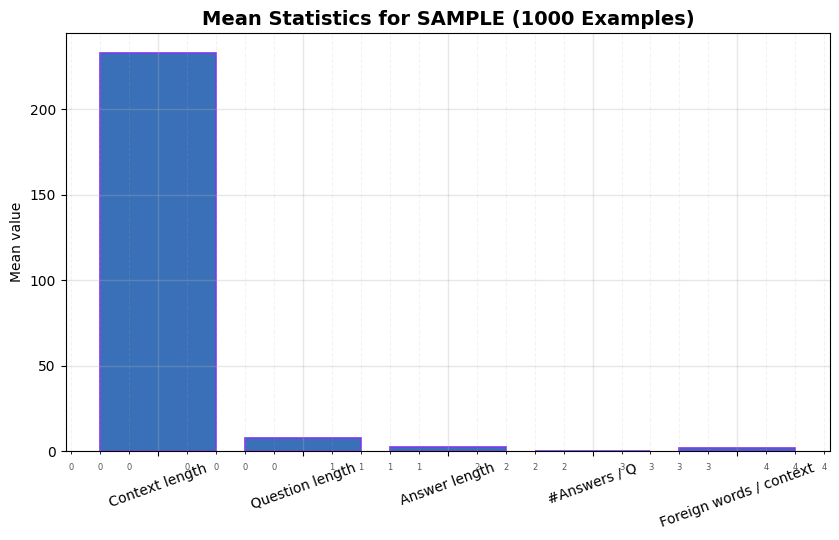

Saved → arabicaqa_rag_results/ragas_full\figures\mean_statistics_sample.png
Saved → arabicaqa_rag_results/ragas_full\figures\mean_statistics_sample.pdf


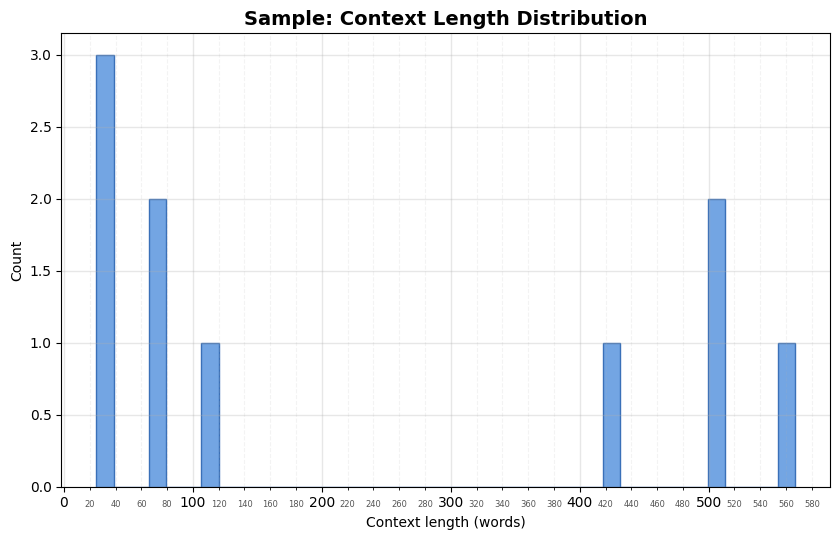

Saved → arabicaqa_rag_results/ragas_full\figures\hist_context_length.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_context_length.pdf


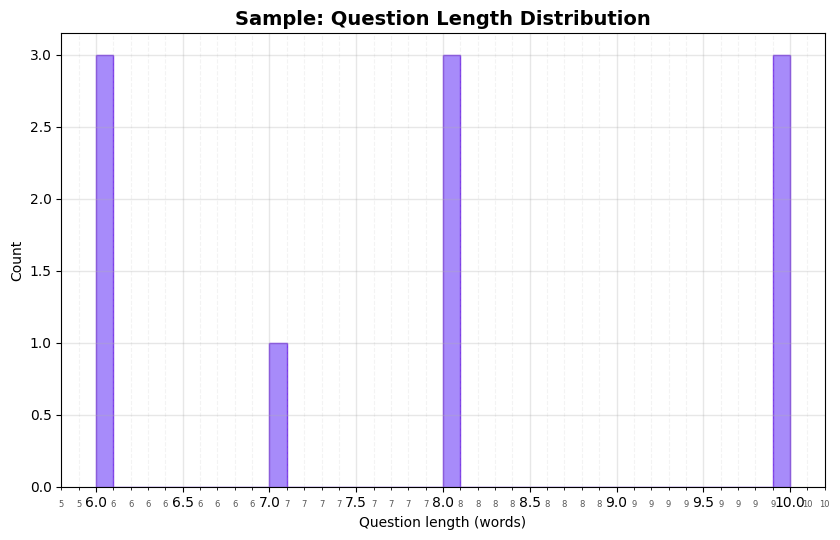

Saved → arabicaqa_rag_results/ragas_full\figures\hist_question_length.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_question_length.pdf


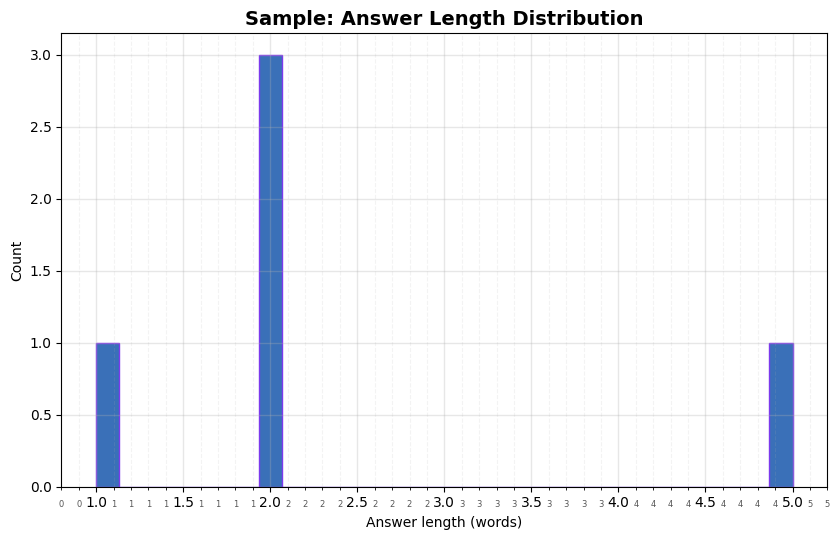

Saved → arabicaqa_rag_results/ragas_full\figures\hist_answer_length.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_answer_length.pdf


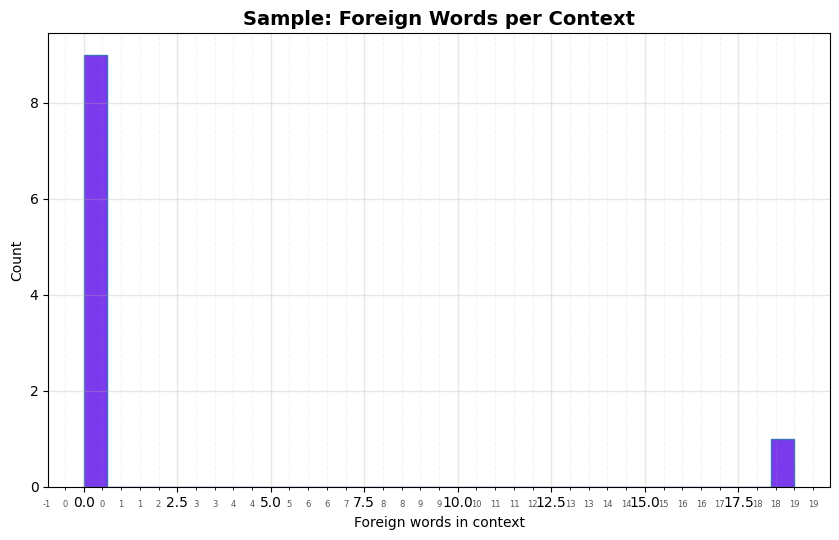

Saved → arabicaqa_rag_results/ragas_full\figures\hist_foreign_words.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_foreign_words.pdf


In [91]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# ======================
# PATHS
# ======================
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# THEME
# ======================
plt.style.use("default")

PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple


def apply_style_with_minor_ticks(ax):
    """Apply theme + grid + minor ticks with small labels"""
    ax.grid(which="major", alpha=0.3, linewidth=1)
    ax.grid(which="minor", alpha=0.15, linestyle="--")

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    minor_ticks = ax.xaxis.get_minorticklocs()
    for tick in minor_ticks:
        ax.text(
            tick,
            -0.045,
            f"{int(tick)}",
            transform=ax.get_xaxis_transform(),
            fontsize=6,
            color="#555555",
            ha="center"
        )

    plt.tight_layout()


# =====================================================
# 1) BAR CHART — MEAN STATISTICS
# =====================================================
labels = [
    "Context length",
    "Question length",
    "Answer length",
    "#Answers / Q",
    "Foreign words / context",
]

values = [
    mean_context_len_s,
    mean_question_len_s,
    mean_answer_len_s,
    mean_n_answers_s,
    mean_foreign_s,
]

fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.bar(labels, values, color=PRIMARY, edgecolor=ACCENT2, linewidth=1.2)
ax.set_ylabel("Mean value")
ax.set_title("Mean Statistics for SAMPLE (1000 Examples)", fontsize=14, weight="bold")
ax.tick_params(axis="x", rotation=20)

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "mean_statistics_sample.png")
pdf = os.path.join(FIG_DIR, "mean_statistics_sample.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 2) HISTOGRAM — CONTEXT LENGTH
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_sample["context_word_len"], bins=40,
        color=SECONDARY, edgecolor=PRIMARY)

ax.set_xlabel("Context length (words)")
ax.set_ylabel("Count")
ax.set_title("Sample: Context Length Distribution", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_context_length.png")
pdf = os.path.join(FIG_DIR, "hist_context_length.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 3) HISTOGRAM — QUESTION LENGTH
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_sample["question_word_len"], bins=40,
        color=ACCENT1, edgecolor=ACCENT2)

ax.set_xlabel("Question length (words)")
ax.set_ylabel("Count")
ax.set_title("Sample: Question Length Distribution", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_question_length.png")
pdf = os.path.join(FIG_DIR, "hist_question_length.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 4) HISTOGRAM — ANSWER LENGTH
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(all_sample_answer_lengths, bins=30,
        color=PRIMARY, edgecolor=ACCENT2)

ax.set_xlabel("Answer length (words)")
ax.set_ylabel("Count")
ax.set_title("Sample: Answer Length Distribution", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_answer_length.png")
pdf = os.path.join(FIG_DIR, "hist_answer_length.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 5) HISTOGRAM — FOREIGN WORDS PER CONTEXT
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_sample["foreign_words"], bins=30,
        color=ACCENT2, edgecolor=PRIMARY)

ax.set_xlabel("Foreign words in context")
ax.set_ylabel("Count")
ax.set_title("Sample: Foreign Words per Context", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_foreign_words.png")
pdf = os.path.join(FIG_DIR, "hist_foreign_words.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


In [3]:
import pandas as pd
import json

# ========== Load sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample_loaded = pd.read_csv(sample_path)

# ========== Fix list columns after loading ==========
list_columns = ["answers"]

for col in list_columns:
    df_sample_loaded[col] = df_sample_loaded[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

print("✨ Loaded sample shape:", df_sample_loaded.shape)
df_sample_loaded.head()


✨ Loaded sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [9]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd
from tqdm import tqdm
from collections import Counter

model_id = "CAMeL-Lab/bert-base-arabic-camelbert-msa-ner"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForTokenClassification.from_pretrained(model_id)

ner = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

def get_entity_counts(texts, max_tokens=512):
    entity_counter = Counter()
    for t in tqdm(texts):
        if not isinstance(t, str) or not t.strip():
            continue

        # نعمل tokenize مع قصّ لحد max_tokens
        enc = tokenizer(
            t,
            truncation=True,
            max_length=max_tokens,
            return_tensors=None
        )
        # نرجع نص مقصوص بناء على التوكنز
        input_ids = enc["input_ids"]
        # لو رجعها list of ids (بدون batch)
        if isinstance(input_ids[0], int):
            truncated_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        else:
            truncated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

        # نرسل النص المقصوص للـ pipeline بدون براميترز إضافية
        ents = ner(truncated_text)
        for e in ents:
            entity_counter[e["entity_group"]] += 1

    return entity_counter


# ==============================
# SAMPLE entities (ACTIVE)
# ==============================
sample_contexts = df_sample_loaded["context"].dropna().tolist()

sample_entity_counts = get_entity_counts(sample_contexts)

print("\n=== SAMPLE NER STATISTICS ===")
for k, v in sample_entity_counts.items():
    print(f"{k}: {v}")

df_ner = pd.DataFrame({
    "entity_type": list(sample_entity_counts.keys()),
    "sample": list(sample_entity_counts.values()),
})
df_ner.head()


Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:53<00:00,  3.41it/s]


=== SAMPLE NER STATISTICS ===
ORG: 2058
LOC: 11581
PERS: 6686
MISC: 3737


,entity_type,sample
0,ORG,2058
1,LOC,11581
2,PERS,6686
3,MISC,3737


In [86]:
import pandas as pd

ner_results_path = "arabicaqa_rag_results/dataset/sample_ner_counts.csv"

df_ner_loaded = pd.read_csv(ner_results_path)

print("✨ Loaded NER results:")
print(df_ner_loaded.head())


✨ Loaded NER results:
  entity_type  sample
0         ORG    2058
1         LOC   11581
2        PERS    6686
3        MISC    3737


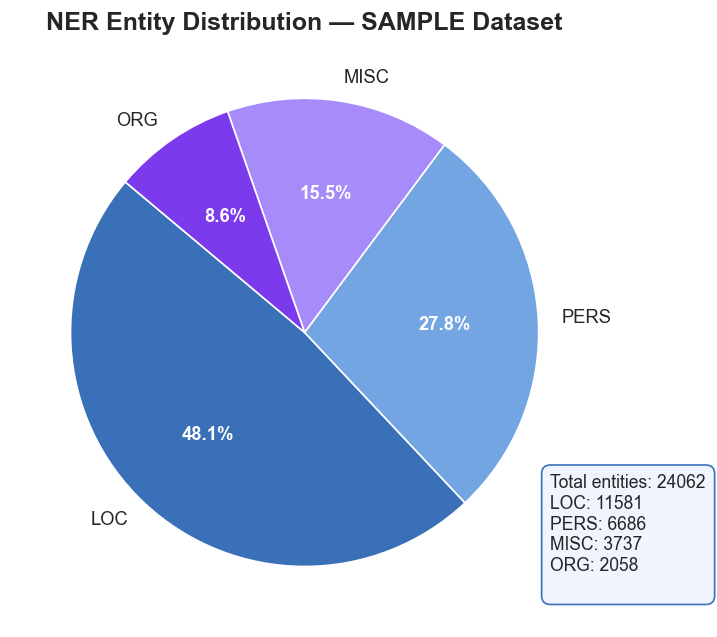

Saved → arabicaqa_rag_results/ragas_full\figures\ner_entity_distribution_pie.png
Saved → arabicaqa_rag_results/ragas_full\figures\ner_entity_distribution_pie.pdf


In [87]:
import os
import matplotlib.pyplot as plt

# ====== Theme colors ======
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

colors = [PRIMARY, SECONDARY, ACCENT1, ACCENT2, "#4FB6A0", "#F2A93B", "#D96459"]

# ======================
# PATH
# ======================
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# PREPARE DATA
# ======================
df_plot = df_ner_loaded.sort_values("sample", ascending=False)

labels = df_plot["entity_type"].astype(str).tolist()
sizes  = df_plot["sample"].astype(float).tolist()

total_entities = int(sum(sizes))

# ======================
# PIE CHART
# ======================
fig, ax = plt.subplots(figsize=(6.5, 5.5))

patches, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors[:len(labels)],
    startangle=140,
    textprops={"fontsize": 11}
)

# improve label style on wedges
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontsize(11)
    autotext.set_weight("bold")

ax.set_title("NER Entity Distribution — SAMPLE Dataset", fontsize=15, weight="bold")

# ========= Inset Box ==========
box_text = f"Total entities: {total_entities}\n"
for ent, count in zip(labels, sizes):
    box_text += f"{ent}: {int(count)}\n"

props = dict(boxstyle="round,pad=0.5", facecolor="#F0F4FF", edgecolor=PRIMARY)

ax.text(
    0.92, 0.05,                 # box position inside axes
    box_text,
    transform=ax.transAxes,
    fontsize=10.5,
    verticalalignment="bottom",
    horizontalalignment="left",
    bbox=props
)

plt.tight_layout()

# ======================
# SAVE
# ======================
png_path = os.path.join(FIG_DIR, "ner_entity_distribution_pie.png")
pdf_path = os.path.join(FIG_DIR, "ner_entity_distribution_pie.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()

print(f"Saved → {png_path}")
print(f"Saved → {pdf_path}")


# **RAG Pipeline**

In [55]:
import pandas as pd
import json

# ========== Load sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample_loaded = pd.read_csv(sample_path)

# ========== Fix list columns after loading ==========
list_columns = ["answers"]

for col in list_columns:
    df_sample_loaded[col] = df_sample_loaded[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

print("✨ Loaded sample shape:", df_sample_loaded.shape)
df_sample_loaded.head()


✨ Loaded sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [56]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain_classic.chains import RetrievalQA


print("✅ all imports OK (new LangChain)")


✅ all imports OK (new LangChain)


In [57]:
# ========= 1) جهّزي الـ corpus مع document_id =========
unique_contexts = (
    df_sample_loaded[["document_id", "context"]]
    .dropna(subset=["context"])
    .drop_duplicates(subset=["document_id"])
    .reset_index(drop=True)
)

len(unique_contexts), unique_contexts.iloc[0]["context"][:200]


(919,
 'توب غولف هي شركة ترفيهية رياضية عالمية مقرها في دالاس، تكساس ولها مواقع في الولايات المتحدة والمملكة المتحدة وأستراليا والمكسيك ودبي. تم الاستحواذ على الشركة من قبل Callaway Golf المتداولة علنًا في ما')

In [58]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

unique_contexts = (
    df_sample_loaded[["document_id", "context"]]
    .dropna(subset=["context"])
    .drop_duplicates(subset=["document_id"])
    .reset_index(drop=True)
)

docs = []
for _, row in unique_contexts.iterrows():
    doc_id = int(row["document_id"])
    text = row["context"]

    chunks = text_splitter.split_text(text)
    for i, chunk in enumerate(chunks):
        docs.append(
            Document(
                page_content=chunk,
                metadata={"document_id": doc_id, "chunk_id": i}
            )
        )

print("Example metadata:", docs[0].metadata)
print(f"✅ Created {len(docs)} chunks")


Example metadata: {'document_id': 1732461, 'chunk_id': 0}
✅ Created 6026 chunks


In [59]:
# ========= 3) بناء الـ Vector DB (Chroma + HF embeddings) =========
from langchain_community.vectorstores import Chroma
from tqdm.auto import tqdm  

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

vectordb = Chroma(
    collection_name="arabicaqa_mrc_v1_docid",   # اسم جديد
    embedding_function=embeddings,
    persist_directory="chroma_arabicaqa_docid"  # مجلد جديد
)

BATCH_SIZE = 5000
for i in tqdm(range(0, len(docs), BATCH_SIZE)):
    batch_docs = docs[i : i + BATCH_SIZE]
    vectordb.add_documents(batch_docs)

vectordb.persist()

retriever = vectordb.as_retriever(search_kwargs={"k": 5})


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: de39c4df-ef39-41c8-b632-e786bf614be6)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:21<00:00, 70.79s/it]


In [60]:
hits = retriever.invoke(df_results["question"].iloc[0])
print(hits[0].metadata)


{'chunk_id': 4, 'document_id': 1732461}


In [61]:
import pandas as pd
import json
import time
import os
from tqdm import tqdm

from langchain_community.llms import Ollama
from langchain_core.prompts import PromptTemplate
from langchain_classic.chains import RetrievalQA

# ========== 1) Load the sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample = pd.read_csv(sample_path)

# ========== Smoke test: 5 Answerable + 5 Unanswerable ==========
df_ans  = df_sample[df_sample["is_impossible"] == True].head(5)
df_un   = df_sample[df_sample["is_impossible"] == False].head(5)

df_sample = pd.concat([df_ans, df_un], ignore_index=True)

print("Smoke test mode (5 answerable + 5 unanswerable):", df_sample.shape)
print(df_sample["is_impossible"].value_counts())

# ========================================================================

# Fix list columns after CSV loading (answers as JSON list)
list_columns = ["answers"]  # لو عندك أعمدة أخرى من نوع list أضيفيها هنا
for col in list_columns:
    if col in df_sample.columns:
        df_sample[col] = df_sample[col].apply(
            lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else x
        )

print("Sample loaded successfully:", df_sample.shape)

# تأكد أن عمود is_impossible موجود
if "is_impossible" not in df_sample.columns:
    raise ValueError("Column 'is_impossible' is missing from df_sample!")

# ========== 2) Shared Prompt (نفس البرومبت للموديلين) ==========
template = """
أجب عن السؤال التالي باللغة العربية الفصحى فقط،
وبأقصر وأدق إجابة ممكنة.
لا تضف أي شرح أو مقدمة أو معلومات من خارج السياق.
إذا لم تكن الإجابة موجودة في السياق، اكتب فقط: "غير موجود في السياق."

السؤال: {question}

السياق:
{context}

الإجابة:
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["question", "context"]
)

# ========== 3) Define the two models ==========
models = {
    "llama": "llama3:latest",
    "mistral": "mistral:7b-instruct",
}

# نفترض أن retriever موجود من قبل في النوتبوك
# retriever = vectordb.as_retriever(search_kwargs={"k": 5})

qa_chains = {}
for name, model_name in models.items():
    llm = Ollama(model=model_name, temperature=0.0)
    qa_chains[name] = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=False,
    )

# ========== 4) Run both models on all questions ==========
results = []

print("Starting dual-model RAG evaluation (Llama vs Mistral) on 1000 questions...\n")

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Processing questions"):
    question = row["question"]
    context = row.get("context", "")

    answer_llama = "ERROR"
    answer_mistral = "ERROR"

    # Run Llama
    try:
        # بعض إصدارات LangChain تفضّل هذا الشكل:
        answer_llama = qa_chains["llama"]({"query": question})["result"].strip()
    except Exception as e:
        print(f"\nLlama error on question {idx}: {e}")

    # Run Mistral
    try:
        answer_mistral = qa_chains["mistral"]({"query": question})["result"].strip()
    except Exception as e:
        print(f"\nMistral error on question {idx}: {e}")

    results.append({
        # من نفس الداتا الأصلية
        "row_idx": idx,                               # فهرس السطر في السامبل
        "split": row.get("split", ""),
        "document_id": row.get("document_id", ""),
        "question_id": row.get("question_id", ""),

        "question": question,
        "context": context,
        "correct_answers": row["answers"],           # قائمة الإجابات الصحيحة (list)

        # معلومات قابلية الإجابة
        "is_impossible": bool(row.get("is_impossible", False)),
        "is_answerable": not bool(row.get("is_impossible", False)),

        # مخرجات الموديلين
        "predicted_answer_llama": answer_llama,
        "predicted_answer_mistral": answer_mistral,
    })

    # نفس التوقف الصغير عشان Ollama ما يتعب
    time.sleep(0.15)

# ========== 5) Save results ==========
df_results = pd.DataFrame(results)

output_dir = "arabicaqa_rag_results/predictions"
os.makedirs(output_dir, exist_ok=True)

output_csv = f"{output_dir}/comparison_llama_vs_mistral_1000.csv"
output_json = f"{output_dir}/comparison_llama_vs_mistral_1000.json"

# ملاحظة: correct_answers عمود list → CSV راح يخزّنه كنص
df_results.to_csv(output_csv, index=False, encoding="utf-8-sig")
df_results.to_json(output_json, orient="records", lines=True, force_ascii=False)

print("\nAll done! Dual model evaluation completed.")
print(f"Results saved:")
print(f"   CSV  → {output_csv}")
print(f"   JSON → {output_json}")
print(f"   Total questions: {len(df_results)}")
print(f"   Llama errors:   {(df_results['predicted_answer_llama'] == 'ERROR').sum()}")
print(f"   Mistral errors: {(df_results['predicted_answer_mistral'] == 'ERROR').sum()}")


Smoke test mode (5 answerable + 5 unanswerable): (10, 7)
is_impossible
True     5
False    5
Name: count, dtype: int64
Sample loaded successfully: (10, 7)
Starting dual-model RAG evaluation (Llama vs Mistral) on 1000 questions...



Processing questions: 100%|████████████████████████████████████████████████████████████| 10/10 [11:25<00:00, 68.58s/it]


All done! Dual model evaluation completed.
Results saved:
   CSV  → arabicaqa_rag_results/predictions/comparison_llama_vs_mistral_1000.csv
   JSON → arabicaqa_rag_results/predictions/comparison_llama_vs_mistral_1000.json
   Total questions: 10
   Llama errors:   0
   Mistral errors: 0


In [62]:
from evaluate import load
import json
from datetime import datetime
print("\n" + "="*80)
print(" CALCULATING OFFICIAL SCORES")
print("="*80)

from evaluate import load
import math

em_metric  = load("exact_match")
em25_metric = load("exact_match", "exact_match_25")

def normalize_refs(refs):
    # None
    if refs is None:
        return [""]

    # NaN (float)
    if isinstance(refs, float) and math.isnan(refs):
        return [""]

    # string
    if isinstance(refs, str):
        s = refs.strip()
        return [s] if s else [""]

    # list/tuple
    if isinstance(refs, (list, tuple)):
        # flatten one-level nested list like [[...]]
        if len(refs) == 1 and isinstance(refs[0], (list, tuple)):
            refs = refs[0]

        # remove None/NaN/empty strings, cast to str
        cleaned = []
        for r in refs:
            if r is None:
                continue
            if isinstance(r, float) and math.isnan(r):
                continue
            r = str(r).strip()
            if r:
                cleaned.append(r)

        return cleaned if cleaned else [""]

    # any other type
    s = str(refs).strip()
    return [s] if s else [""]


def normalize_pred(pred):
    if pred is None:
        return ""
    if isinstance(pred, float) and math.isnan(pred):
        return ""
    return str(pred)

def compute_scores(predictions, references_list):
    em_scores, em25_scores = [], []

    for pred, refs in zip(predictions, references_list):
        pred = normalize_pred(pred)
        refs = normalize_refs(refs)

        best_em = max(
            em_metric.compute(
                predictions=[pred],
                references=[ref],
                ignore_case=True,
                ignore_punctuation=True
            )["exact_match"]
            for ref in refs
        )
        em_scores.append(best_em)

        best_em25 = max(
            em25_metric.compute(
                predictions=[pred],
                references=[ref],
                ignore_case=True,
                ignore_punctuation=True
            )["exact_match"]
            for ref in refs
        )
        em25_scores.append(best_em25)

    avg_em = round(sum(em_scores) / len(em_scores) * 100, 2) if em_scores else 0.0
    avg_em25 = round(sum(em25_scores) / len(em25_scores) * 100, 2) if em25_scores else 0.0
    return avg_em, avg_em25

# Compute
llama_preds = df_results["predicted_answer_llama"].tolist()
mistral_preds = df_results["predicted_answer_mistral"].tolist()
gold_answers = [normalize_refs(r) for r in df_results["correct_answers"].tolist()]

em_llama, em25_llama = compute_scores(llama_preds, gold_answers)
em_mistral, em25_mistral = compute_scores(mistral_preds, gold_answers)

# Determine winner
winner = "Mistral-7B-Instruct" if em25_mistral > em25_llama else "Llama-3.1-8B"
diff = abs(em25_mistral - em25_llama)

# Print beautiful table
print(f"{'Model':<25} {'EM ↑':>10} {'EM25 ↑':>12}")
print("-" * 70)
print(f"{'Llama-3.1-8B':<25} {em_llama:>9.2f}% {em25_llama:>11.2f}%")
print(f"{'Mistral-7B-Instruct':<25} {em_mistral:>9.2f}% {em25_mistral:>11.2f}%")
print("-" * 70)
print(f"Winner → {winner} (by {diff:.2f} points on EM25)")
print("="*80)

# ========== Save results in multiple pro formats ==========
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
summary = {
    "date": datetime.now().isoformat(),
    "dataset": "Arabica QA (1,000 questions sample)",
    "retriever": str(retriever.__class__.__name__),
    "chunk_size": "unknown", # عدّلها لو تعرف
    "results": {
        "Llama-3.1-8B": {"EM": em_llama, "EM25": em25_llama},
        "Mistral-7B-Instruct": {"EM": em_mistral, "EM25": em25_mistral},
        "winner": winner,
        "winner_margin": round(diff, 2)
    }
}

# 1. Human-readable TXT
with open(f"{output_dir}/FINAL_SCORES.txt", "w", encoding="utf-8") as f:
    f.write("Arabica QA RAG Evaluation – Final Results\n")
    f.write("="*50 + "\n")
    f.write(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
    f.write(f"Questions : 1,000\n\n")
    f.write(f"Llama-3.1-8B → EM: {em_llama:6.2f}% | EM25: {em25_llama:6.2f}%\n")
    f.write(f"Mistral-7B-Instruct → EM: {em_mistral:6.2f}% | EM25: {em25_mistral:6.2f}%\n")
    f.write(f"\nWinner: {winner} (+{diff:.2f} pts)\n")

# 2. JSON (للريبو و leaderboard)
with open(f"{output_dir}/final_results.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

# 3. Markdown (جاهز للـ README أو التغريدة)
markdown_table = f"""
| Model               | EM      | EM25     |
|---------------------|---------|----------|
| Llama-3.1-8B        | {em_llama:.2f}% | {em25_llama:.2f}% |
| Mistral-7B-Instruct | {em_mistral:.2f}% | {em25_mistral:.2f}% |
| **Winner**          | —       | **{winner}** (+{diff:.2f} pts) |
"""

with open(f"{output_dir}/README.md", "w", encoding="utf-8") as f:
    f.write("# Arabic RAG Leaderboard Result\n\n")
    f.write(markdown_table)

print("All results saved successfully!")
print(f" TXT → {output_dir}/FINAL_SCORES.txt")
print(f" JSON → {output_dir}/final_results.json")
print(f" MD → {output_dir}/README.md ← ready for sharing or repository use")


 CALCULATING OFFICIAL SCORES
Model                           EM ↑       EM25 ↑
----------------------------------------------------------------------
Llama-3.1-8B                   0.00%        0.00%
Mistral-7B-Instruct            0.00%        0.00%
----------------------------------------------------------------------
Winner → Llama-3.1-8B (by 0.00 points on EM25)
All results saved successfully!
 TXT → arabicaqa_rag_results/predictions/FINAL_SCORES.txt
 JSON → arabicaqa_rag_results/predictions/final_results.json
 MD → arabicaqa_rag_results/predictions/README.md ← ready for sharing or repository use


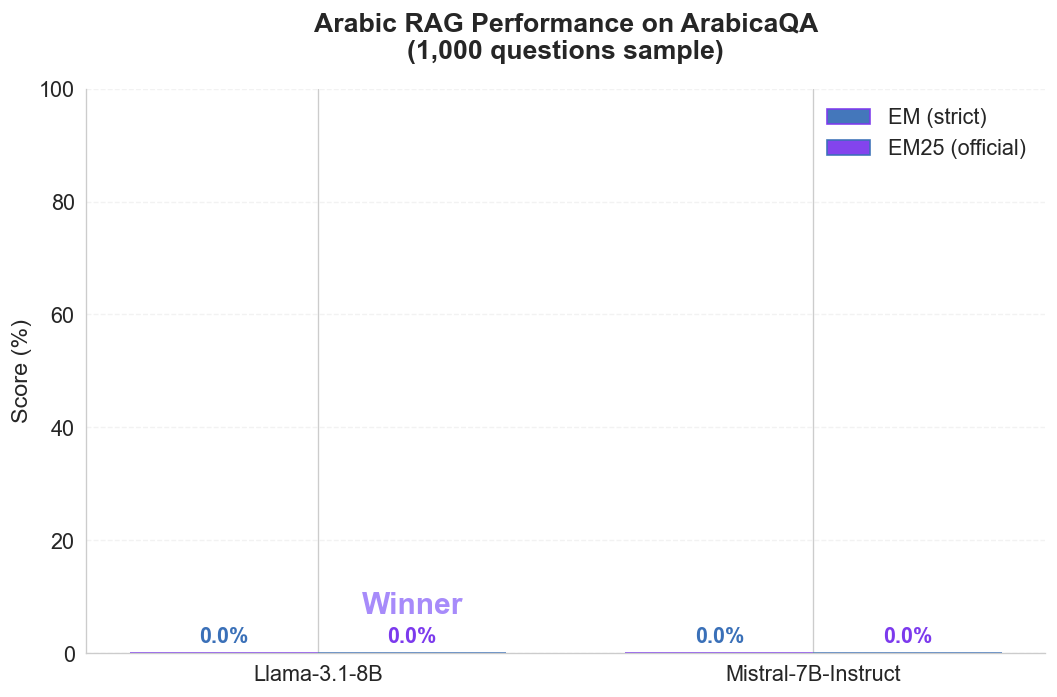

Plot saved → arabicaqa_rag_results/predictions/arabica_qa_final_result.png
PDF version also saved for papers → arabicaqa_rag_results/predictions/arabica_qa_final_result.pdf


In [83]:
# ========== 7) Beautiful final plot (theme version) ==========
import matplotlib.pyplot as plt
import numpy as np
import os

# ====== Theme colors ======
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 13

# Data
models = ["Llama-3.1-8B", "Mistral-7B-Instruct"]
em_values   = [em_llama, em_mistral]
em25_values = [em25_llama, em25_mistral]

# positions
x = np.arange(len(models))
w = 0.38

fig, ax = plt.subplots()

# bars (theme)
bars1 = ax.bar(
    x - w/2, em_values, width=w,
    label="EM (strict)",
    color=PRIMARY, edgecolor=ACCENT2, linewidth=1.0, alpha=0.95
)

bars2 = ax.bar(
    x + w/2, em25_values, width=w,
    label="EM25 (official)",
    color=ACCENT2, edgecolor=PRIMARY, linewidth=1.0, alpha=0.95
)

# Add values on top of bars
for i, (em, em25) in enumerate(zip(em_values, em25_values)):
    ax.text(
        x[i] - w/2, em + 1.2, f"{em:.1f}%",
        ha="center", va="bottom", fontweight="bold", fontsize=13, color=PRIMARY
    )
    ax.text(
        x[i] + w/2, em25 + 1.2, f"{em25:.1f}%",
        ha="center", va="bottom", fontweight="bold", fontsize=13, color=ACCENT2
    )

# Winner label (based on EM25)
winner_idx = 1 if em25_mistral > em25_llama else 0
ax.text(
    x[winner_idx] + w/2, max(em25_values) + 6, "Winner",
    ha="center", va="bottom", fontsize=18, fontweight="bold", color=ACCENT1
)

# Styling
ax.set_ylabel("Score (%)", fontsize=14)
ax.set_title(
    "Arabic RAG Performance on ArabicaQA\n(1,000 questions sample)",
    fontsize=16, pad=18, fontweight="bold"
)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=13)
ax.set_ylim(0, 100)

ax.legend(loc="upper right", frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.25)

# Clean spines (like seaborn.despine but manual)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save high quality
os.makedirs(output_dir, exist_ok=True)
png_path = f"{output_dir}/arabica_qa_final_result.png"
pdf_path = f"{output_dir}/arabica_qa_final_result.pdf"

plt.tight_layout()
plt.savefig(png_path, dpi=400, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()

print(f"Plot saved → {png_path}")
print(f"PDF version also saved for papers → {pdf_path}")


In [64]:
import ast
import pandas as pd

path = "arabicaqa_rag_results/predictions/"

df = pd.read_csv(path+"comparison_llama_vs_mistral_1000.csv", encoding="utf-8")

print(df.shape)
df.head(3)

def parse_correct_answers(x):
    if pd.isna(x) or x is None:
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        s = x.strip()
        # common case: "['...']"
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list):
                return [str(v).strip() for v in parsed if str(v).strip()]
            # if it's a single value, wrap it
            return [str(parsed).strip()] if str(parsed).strip() else []
        except Exception:
            # fallback: treat whole string as one answer
            return [s] if s else []
    return []

df["correct_answers"] = df["correct_answers"].apply(parse_correct_answers)

# verify
print(df["correct_answers"].apply(type).value_counts())
print(df["correct_answers"].head(3))

df.to_csv(
    path+"comparison_llama_vs_mistral_1000_clean.csv",
    index=False,
    encoding="utf-8-sig"
)

df_clean = pd.read_csv(path+"comparison_llama_vs_mistral_1000_clean.csv", encoding="utf-8")

df_clean["correct_answers"] = df_clean["correct_answers"].apply(parse_correct_answers)
print(df_clean["correct_answers"].apply(type).value_counts())


print(df_clean.shape)
df_clean.head(3)

(10, 11)
correct_answers
<class 'list'>    10
Name: count, dtype: int64
0    []
1    []
2    []
Name: correct_answers, dtype: object
correct_answers
<class 'list'>    10
Name: count, dtype: int64
(10, 11)


,row_idx,split,document_id,question_id,question,context,correct_answers,is_impossible,is_answerable,predicted_answer_llama,predicted_answer_mistral
0,0,train,1450918,967260,ما هي التحديات التي واجهها رؤوف دنكتاش خلال فت...,رؤوف دنكتاش (27 يناير 1924 - 13 يناير 2012) كا...,[],True,False,غير موجود في السياق.,رؤوف دنكتاش واجه تحديات بدنية وكتابية خلال فتر...
1,1,train,1533757,1065260,ما هي الكثافة السكانية في ورثينجتون؟,ورثينجتون هي منطقة سكنية تقع بولاية بنسيلفانيا...,[],True,False,كثافة السكانية في ورثينجتون: .,الكثافة السكانية في ورثينجتون هي 362.8 نسمة/م².
2,2,train,1449966,924343,ما هي الطريقة التي يتم بها كتابة الحروف في الق...,القَافَة وتسمى أيضًا طريقة برايل نسبةً لمخترعه...,[],True,False,تُكتب الحروف رموزاً بارزة على الورق.,في القافة، يتم كتابة الحروف بأشكال مختلفة من ا...


In [65]:
df_clean.columns.tolist()


['row_idx',
 'split',
 'document_id',
 'question_id',
 'question',
 'context',
 'correct_answers',
 'is_impossible',
 'is_answerable',
 'predicted_answer_llama',
 'predicted_answer_mistral']

In [66]:
df_clean["correct_answers"].head(5)
df_clean["correct_answers"].apply(type).value_counts()


correct_answers
<class 'list'>    10
Name: count, dtype: int64

In [67]:
df_clean["correct_answers"].iloc[0]


[]

In [68]:
import os
import ast
import math
import pandas as pd
from tqdm import tqdm

from ragas import evaluate
from datasets import Dataset
from langchain_community.llms import Ollama
from langchain_community.embeddings import HuggingFaceEmbeddings

# ====================== PATHS ======================
PRED_PATH = "arabicaqa_rag_results/predictions/comparison_llama_vs_mistral_1000.csv"
OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ====================== LOAD CSV ======================
df_results = pd.read_csv(PRED_PATH, encoding="utf-8")
print("Loaded:", df_results.shape)

# ====================== FIX correct_answers (string -> list[str]) ======================
def parse_correct_answers(x):
    if x is None:
        return []
    if isinstance(x, float) and math.isnan(x):
        return []
    if isinstance(x, list):
        return [str(v).strip() for v in x if str(v).strip()]
    if isinstance(x, str):
        s = x.strip()
        try:
            parsed = ast.literal_eval(s)  # handles "['عام 2000']"
            if isinstance(parsed, list):
                return [str(v).strip() for v in parsed if str(v).strip()]
            return [str(parsed).strip()] if str(parsed).strip() else []
        except Exception:
            return [s] if s else []
    return []

df_results["correct_answers"] = df_results["correct_answers"].apply(parse_correct_answers)

print("correct_answers types:")
print(df_results["correct_answers"].apply(type).value_counts())
print("Example correct_answers:", df_results["correct_answers"].iloc[0])

# ========================================================================
import ragas.metrics as rm

# ---- pick metrics that exist in YOUR ragas version ----
answer_relevancy   = getattr(rm, "answer_relevancy", None)
faithfulness       = getattr(rm, "faithfulness", None)
context_recall     = getattr(rm, "context_recall", None)
context_precision  = getattr(rm, "context_precision", None)

# this one differs by version:
# some versions: context_relevancy
# others: context_relevance
context_relevancy  = getattr(rm, "context_relevancy", None) or getattr(rm, "context_relevance", None)

answer_correctness = getattr(rm, "answer_correctness", None)
answer_similarity  = getattr(rm, "answer_similarity", None)

# Build the list safely (skip missing ones)
metrics = [
    m for m in [
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision,
        context_relevancy,
        answer_correctness,
        answer_similarity
    ] if m is not None
]

print("✅ Metrics that will run:", [m.name for m in metrics])

# ====================== CONFIGURATION ======================
RUN_MODEL = 3
# 1 = llama only
# 2 = mistral only
# 3 = both

TOP_K = 5  # how many docs to keep if you need to re-retrieve contexts

# ====================== CONTEXTS ======================
# If you already have retrieved_contexts column, we use it.
# Otherwise we retrieve via your existing retriever object.
if "retrieved_contexts" not in df_results.columns:
    print("No retrieved_contexts found -> retrieving contexts now...")
    contexts_list = []
    for q in tqdm(df_results["question"].tolist(), desc="Retrieving contexts"):
        docs = retriever.invoke(q)  # assumes your retriever exists
        contexts_list.append([d.page_content for d in docs[:TOP_K]])
    df_results["retrieved_contexts"] = contexts_list

# Safety: ensure contexts are list[list[str]]
def normalize_contexts(x):
    if x is None:
        return [""]
    if isinstance(x, str):
        return [x]
    if isinstance(x, list):
        if len(x) == 0:
            return [""]
        return [str(c) for c in x]
    return [str(x)]

df_results["retrieved_contexts"] = df_results["retrieved_contexts"].apply(normalize_contexts)

# ====================== EMBEDDINGS + LOCAL JUDGE ======================
embeddings = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

# Use Gemma2 in Ollama (make sure you've run: ollama pull gemma2:2b)
llm_ragas = Ollama(model="gemma2:2b", temperature=0.0)  # or gemma2:9b

# ====================== WHICH MODELS ======================
if RUN_MODEL == 1:
    models_to_run = ["llama"]
elif RUN_MODEL == 2:
    models_to_run = ["mistral"]
else:
    models_to_run = ["llama", "mistral"]

# ====================== RUN EVALUATION ======================
all_rows = []   # aggregated metric results
nan_rows = []   # NaN diagnostics per metric

# ====================== SPLIT DATA ======================
df_answerable   = df_results[df_results["is_answerable"] == True].copy()
df_unanswerable = df_results[df_results["is_answerable"] == False].copy()

print("Answerable:", df_answerable.shape)
print("Unanswerable:", df_unanswerable.shape)

for model_name in models_to_run:
    for tag, df_eval in [
        ("ANSWERABLE", df_answerable),
        ("UNANSWERABLE", df_unanswerable),
    ]:
        if len(df_eval) == 0:
            continue

        print(f"\nRunning RAGAS for {model_name.upper()} [{tag}]")

        if model_name == "llama":
            answers = df_eval["predicted_answer_llama"].fillna("").astype(str).tolist()
        else:
            answers = df_eval["predicted_answer_mistral"].fillna("").astype(str).tolist()

        ground_truth = df_eval["correct_answers"].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else ""
        ).tolist()

        ragas_dataset = Dataset.from_dict({
            "question": df_eval["question"].fillna("").astype(str).tolist(),
            "answer": answers,
            "contexts": df_eval["retrieved_contexts"].tolist(),
            "ground_truth": ground_truth
        })

        result = evaluate(
            ragas_dataset,
            metrics=metrics,
            llm=llm_ragas,
            embeddings=embeddings,
            raise_exceptions=False
        )

        df_scores = result.to_pandas()

        # ---- prepare row ----
        row = {
            "model": model_name.upper(),
            "subset": tag,
            "n_questions": len(df_eval),
        }

        # ---- NaN diagnostics + safe numeric aggregation ----
        numeric_df = df_scores.select_dtypes(include="number")

        # If no numeric metrics detected, try coercion
        if numeric_df.shape[1] == 0:
            for c in df_scores.columns:
                if c in ["question", "answer", "contexts", "ground_truth"]:
                    continue
                df_scores[c] = pd.to_numeric(df_scores[c], errors="coerce")
            numeric_df = df_scores.select_dtypes(include="number")

        nan_report = numeric_df.isna().sum()
        if nan_report.sum() > 0:
            print("⚠️ NaN diagnostics (failed questions per metric):")
            for k, v in nan_report.items():
                if v > 0:
                    print(f"  - {k}: {v} / {len(df_scores)}")
        else:
            print("✅ No NaNs detected in numeric metrics")

        # ---- store NaN diagnostics for saving ----
        for metric_name, nan_count in nan_report.items():
            nan_rows.append({
                "model": model_name.upper(),
                "subset": tag,
                "metric": metric_name,
                "nan_count": int(nan_count),
                "n_questions": int(len(df_scores)),
                "nan_ratio": float(nan_count / len(df_scores)) if len(df_scores) > 0 else 0.0
            })

        # ---- aggregate means safely ----
        for c in numeric_df.columns:
            row[c] = float(numeric_df[c].mean(skipna=True))

        all_rows.append(row)

    print(f"\n{model_name.upper()} DONE!")

# ====================== SAVE & DISPLAY RESULTS (NO TIMESTAMP) ======================
final_df = pd.DataFrame(all_rows)

cols = ["model", "subset", "n_questions"] + [
    c for c in final_df.columns if c not in ["model", "subset", "n_questions"]
]
final_df = final_df[cols]

csv_path  = f"{OUTPUT_DIR}/ragas_full_results.csv"
json_path = f"{OUTPUT_DIR}/ragas_full_results.json"
md_path   = f"{OUTPUT_DIR}/RAGAS_RESULTS.md"

final_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
final_df.to_json(json_path, orient="records", force_ascii=False, indent=2)

with open(md_path, "w", encoding="utf-8") as f:
    f.write("# RAGAS Full Evaluation Results\n\n")
    f.write("Judge: gemma2:2b (Ollama)\n")
    f.write(f"Models: {', '.join([m.upper() for m in models_to_run])}\n\n")

    try:
        md = final_df.round(4).to_markdown(index=False)
        f.write(md)
    except Exception:
        # fallback: plain text table
        f.write(final_df.round(4).to_string(index=False))

print("\n" + "="*100)
print("RAGAS FULL EVALUATION RESULTS")
print("="*100)
print(final_df.round(4).to_string(index=False))
print("="*100)
print("Saved:")
print(f"  CSV  -> {csv_path}")
print(f"  JSON -> {json_path}")
print(f"  MD   -> {md_path}")

# ====================== SAVE NaN DIAGNOSTICS (NO TIMESTAMP) ======================
nan_df = pd.DataFrame(nan_rows)

nan_csv  = f"{OUTPUT_DIR}/ragas_nan_report.csv"
nan_json = f"{OUTPUT_DIR}/ragas_nan_report.json"

if not nan_df.empty:
    nan_df = nan_df.sort_values(["model", "subset", "metric"])

    nan_df.to_csv(nan_csv, index=False, encoding="utf-8-sig")
    nan_df.to_json(nan_json, orient="records", force_ascii=False, indent=2)

    print(f"  NaN CSV  -> {nan_csv}")
    print(f"  NaN JSON -> {nan_json}")
else:
    print("No NaN diagnostics to save.")


Loaded: (10, 11)
correct_answers types:
correct_answers
<class 'list'>    10
Name: count, dtype: int64
Example correct_answers: []
✅ Metrics that will run: ['answer_relevancy', 'faithfulness', 'context_recall', 'context_precision', 'answer_correctness', 'answer_similarity']
No retrieved_contexts found -> retrieving contexts now...


Retrieving contexts: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.19it/s]


Answerable: (5, 12)
Unanswerable: (5, 12)

Running RAGAS for LLAMA [ANSWERABLE]


Exception raised in Job[15]: TimeoutError()                                             | 9/30 [02:56<07:05, 20.26s/it]
Exception raised in Job[9]: TimeoutError()                                             | 10/30 [03:01<05:16, 15.80s/it]
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[16]: TimeoutError()██████████████████▎                         | 19/30 [03:04<00:37,  3.43s/it]
Exception raised in Job[18]: TimeoutError()████████████████████▋                       | 20/30 [03:06<00:32,  3.29s/it]
Exception raised in Job[19]: TimeoutError()███████████████████████████▋                | 23/30 [03:45<01:01,  8.78s/it]
Exception raised in Job[21]: TimeoutError()████████████████████████████████▎           | 25/30 [

⚠️ NaN diagnostics (failed questions per metric):
  - answer_relevancy: 4 / 5
  - faithfulness: 2 / 5
  - context_precision: 5 / 5
  - answer_correctness: 4 / 5

Running RAGAS for LLAMA [UNANSWERABLE]


Exception raised in Job[1]: TimeoutError()                                              | 5/30 [02:29<15:26, 37.08s/it]
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[15]: TimeoutError()                                             | 6/30 [03:00<13:57, 34.89s/it]
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[16]: TimeoutError()████████████████                            | 18/30 [03:05<01:08,  5.74s/it]
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[21]: TimeoutError()██████████████████████████████████▋         | 26/30 [05:38<01:13, 18.29s/it]
Exception raised in Job[22]: TimeoutError()

⚠️ NaN diagnostics (failed questions per metric):
  - answer_relevancy: 4 / 5
  - faithfulness: 3 / 5
  - context_recall: 1 / 5
  - context_precision: 5 / 5
  - answer_correctness: 5 / 5

LLAMA DONE!

Running RAGAS for MISTRAL [ANSWERABLE]


Exception raised in Job[0]: TimeoutError()                                              | 7/30 [02:22<14:17, 37.27s/it]
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[13]: TimeoutError()                                             | 8/30 [03:00<13:43, 37.42s/it]
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[16]: TimeoutError()██████████████████▎                         | 19/30 [03:05<01:12,  6.63s/it]
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[19]: TimeoutError()█████████████████████████▎                  | 22/30 [03:08<00:41,  5.24s/it]
Exception raised in Job[21]: TimeoutError()██████████████████████████████             

⚠️ NaN diagnostics (failed questions per metric):
  - answer_relevancy: 4 / 5
  - faithfulness: 4 / 5
  - context_precision: 5 / 5
  - answer_correctness: 5 / 5

Running RAGAS for MISTRAL [UNANSWERABLE]


Exception raised in Job[4]: TimeoutError()                                              | 5/30 [02:32<17:38, 42.35s/it]
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()                                              | 6/30 [03:00<15:05, 37.72s/it]
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[16]: TimeoutError()████████████████                            | 18/30 [03:04<01:13,  6.13s/it]
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[19]: TimeoutError()█████████████████████████▎                  | 22/30 [03:48<01:08,  8.58s/it]
Exception raised in Job[22]: TimeoutError

⚠️ NaN diagnostics (failed questions per metric):
  - answer_relevancy: 5 / 5
  - faithfulness: 4 / 5
  - context_recall: 1 / 5
  - context_precision: 5 / 5
  - answer_correctness: 5 / 5

MISTRAL DONE!

RAGAS FULL EVALUATION RESULTS
  model       subset  n_questions  answer_relevancy  faithfulness  context_recall  context_precision  answer_correctness  answer_similarity
  LLAMA   ANSWERABLE            5            0.8602        0.8333          0.6000                NaN              0.9454             0.8269
  LLAMA UNANSWERABLE            5            0.6873        1.0000          0.9167                NaN                 NaN             0.7575
MISTRAL   ANSWERABLE            5            0.0000        1.0000          0.6000                NaN                 NaN             0.8134
MISTRAL UNANSWERABLE            5               NaN        0.5000          1.0000                NaN                 NaN             0.7307
Saved:
  CSV  -> arabicaqa_rag_results/ragas_full/ragas_full_result

Loaded results: (4, 9)
  model       subset  n_questions  answer_relevancy  faithfulness  context_recall  context_precision  answer_correctness  answer_similarity
  LLAMA   ANSWERABLE            5            0.8602        0.8333          0.6000                NaN              0.9454             0.8269
  LLAMA UNANSWERABLE            5            0.6873        1.0000          0.9167                NaN                 NaN             0.7575
MISTRAL   ANSWERABLE            5            0.0000        1.0000          0.6000                NaN                 NaN             0.8134
MISTRAL UNANSWERABLE            5               NaN        0.5000          1.0000                NaN                 NaN             0.7307

Loaded NaN report: (24, 6)
model       subset             metric  nan_count  n_questions  nan_ratio
LLAMA   ANSWERABLE answer_correctness          4            5        0.8
LLAMA   ANSWERABLE   answer_relevancy          4            5        0.8
LLAMA   ANSWERABLE  answer_sim

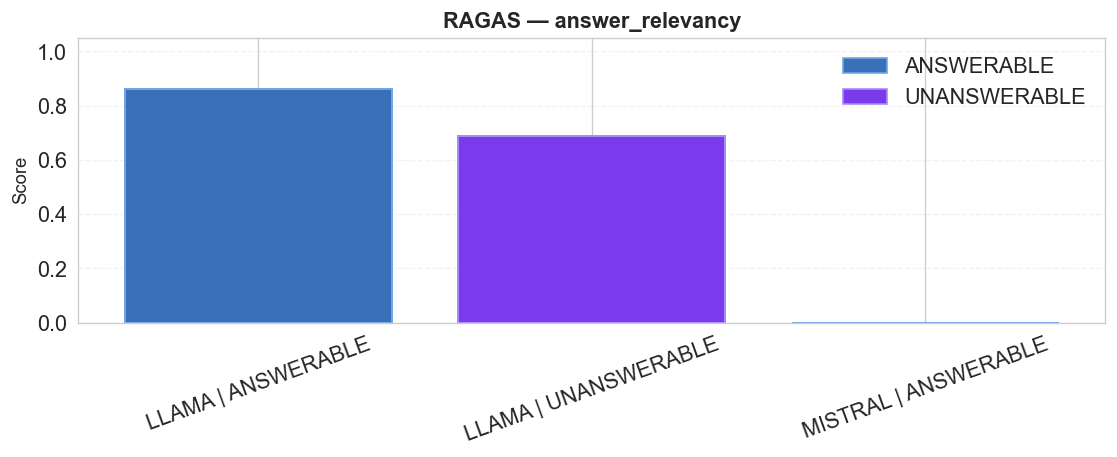

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_answer_relevancy.png


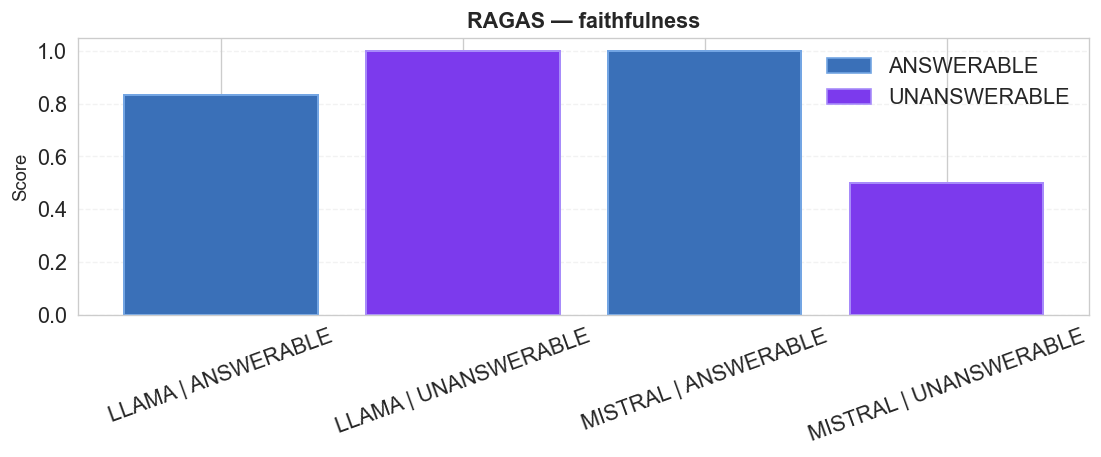

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_faithfulness.png


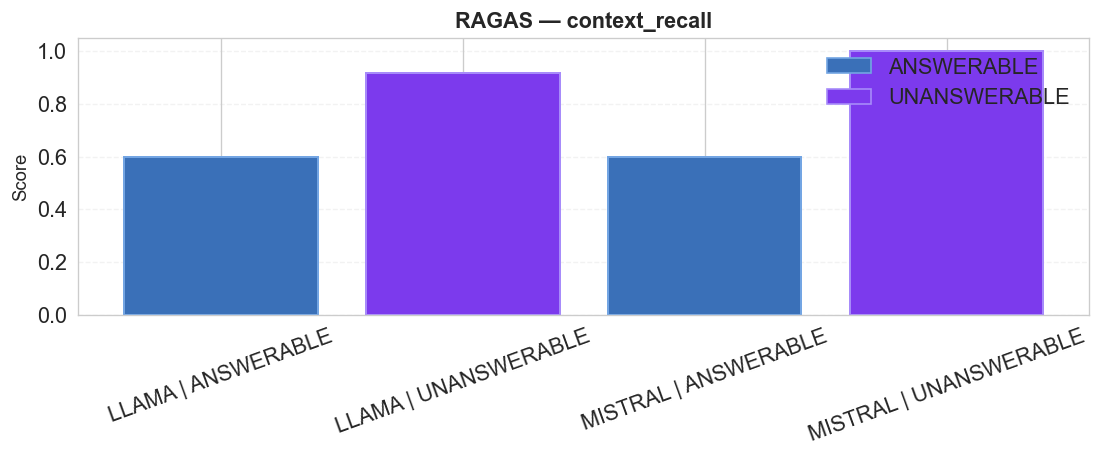

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_context_recall.png


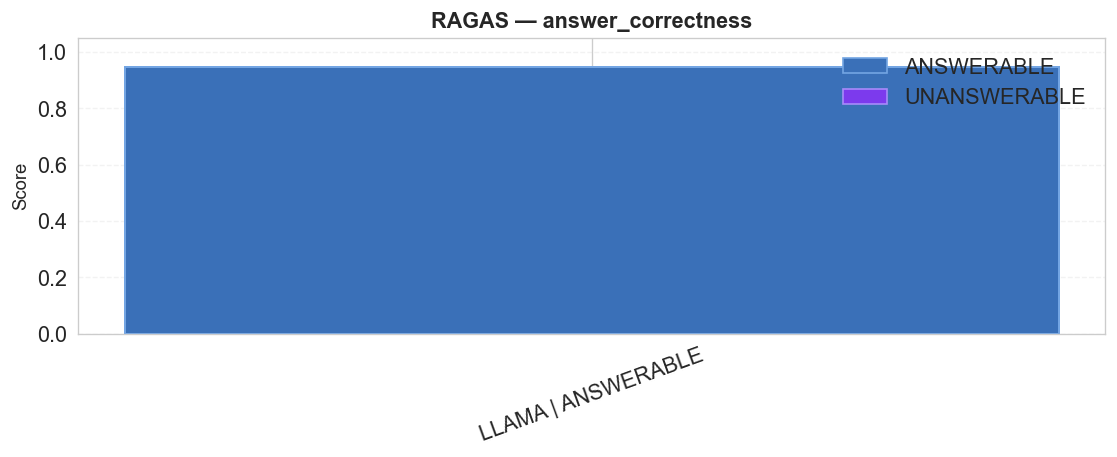

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_answer_correctness.png


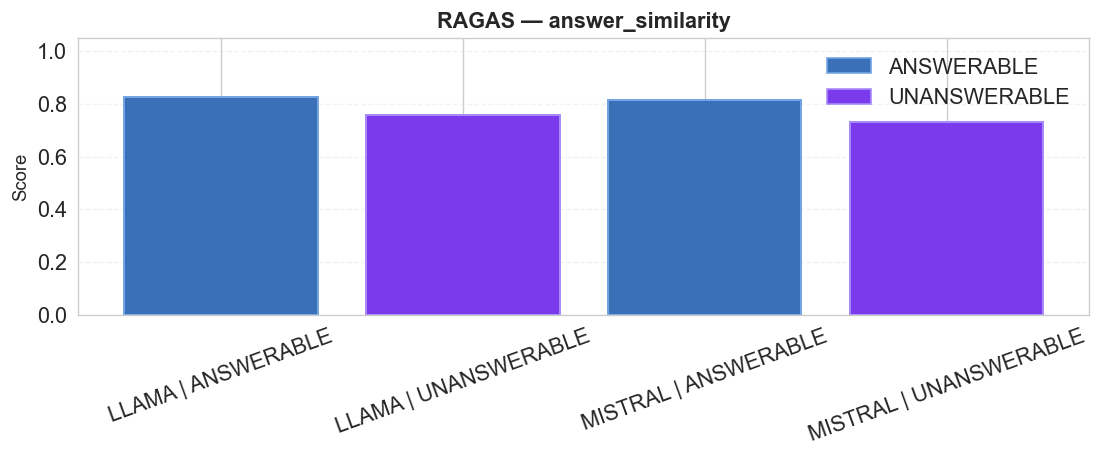

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_answer_similarity.png


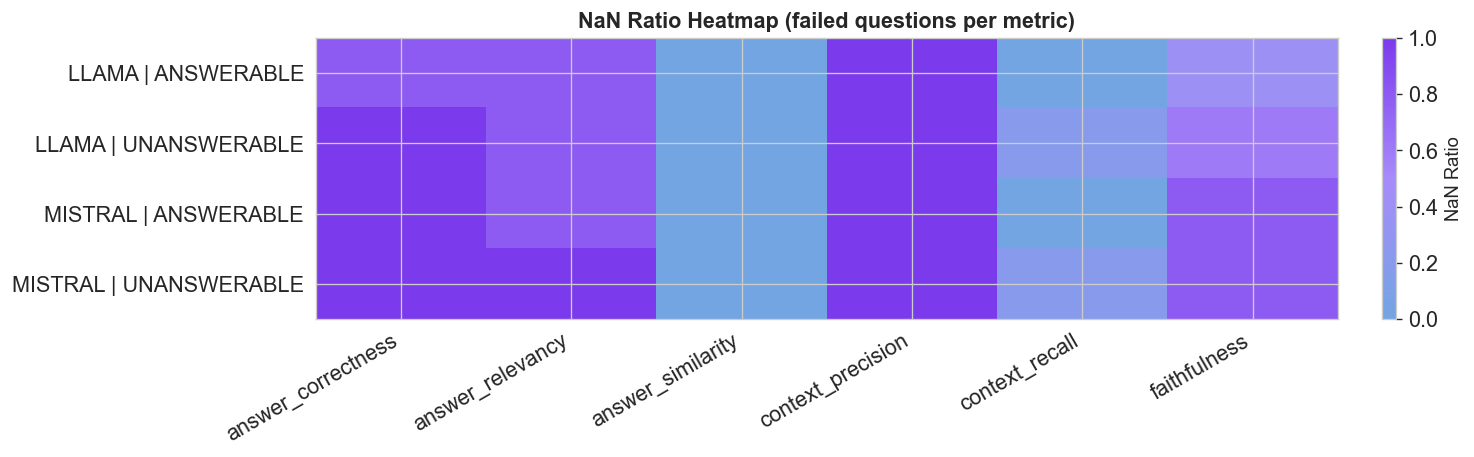

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_nan_heatmap.png


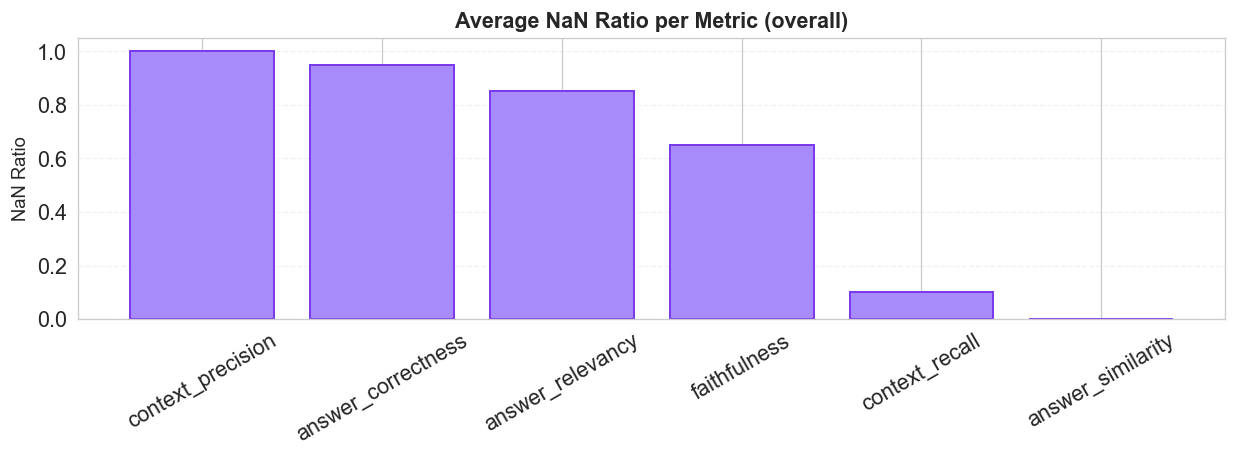

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_nan_ratio_summary.png

Done ✅ Figures saved in: arabicaqa_rag_results/ragas_full\figures


In [84]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
res_path = os.path.join(OUTPUT_DIR, "ragas_full_results.csv")
nan_path = os.path.join(OUTPUT_DIR, "ragas_nan_report.csv")

# ======================
# 0) FIGURES DIR
# ======================
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# 1) LOAD
# ======================
df = pd.read_csv(res_path, encoding="utf-8")
nan_df = pd.read_csv(nan_path, encoding="utf-8") if os.path.exists(nan_path) else None

print("Loaded results:", df.shape)
print(df.round(4).to_string(index=False))

if nan_df is not None:
    print("\nLoaded NaN report:", nan_df.shape)
    print(nan_df.head(10).to_string(index=False))

# ====== Theme colors ======
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

# Apply a light global style (keeps your colors)
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["figure.dpi"] = 120

# ======================
# 2) PREP
# ======================
df_plot = df.copy()
df_plot["model"] = df_plot["model"].astype(str)
df_plot["subset"] = df_plot["subset"].astype(str)
df_plot["group"] = df_plot["model"] + " | " + df_plot["subset"]

id_cols = {"model", "subset", "n_questions", "group"}
metric_cols = [c for c in df_plot.columns if c not in id_cols]

# force numeric
for c in metric_cols:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

metric_cols = [c for c in metric_cols if df_plot[c].notna().any()]
print("\nMetrics columns detected:", metric_cols)

# Color mapping per subset (answerable vs unanswerable)
subset_color = {
    "ANSWERABLE": PRIMARY,
    "UNANSWERABLE": ACCENT2
}

bar_colors = [subset_color.get(s, SECONDARY) for s in df_plot["subset"].tolist()]
edge_colors = [SECONDARY if s == "ANSWERABLE" else ACCENT1 for s in df_plot["subset"].tolist()]

# ======================
# 3) PLOT A: One bar chart per metric (colored by subset) + SAVE
# ======================
for metric in metric_cols:
    fig, ax = plt.subplots(figsize=(9.5, 4))

    values = df_plot[metric].values
    labels = df_plot["group"].tolist()

    ax.bar(
        labels,
        values,
        color=bar_colors,
        edgecolor=edge_colors,
        linewidth=1.2
    )

    ax.set_title(f"RAGAS — {metric}")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis="x", rotation=20)
    ax.grid(axis="y", linestyle="--", alpha=0.25)

    # Legend for subset colors
    legend_items = [
        Patch(facecolor=PRIMARY, edgecolor=SECONDARY, label="ANSWERABLE"),
        Patch(facecolor=ACCENT2, edgecolor=ACCENT1, label="UNANSWERABLE")
    ]
    ax.legend(handles=legend_items, loc="upper right", frameon=False)

    plt.tight_layout()

    # Save
    safe_name = metric.replace("/", "_").replace(" ", "_")
    png_path = os.path.join(FIG_DIR, f"ragas_{safe_name}.png")
    pdf_path = os.path.join(FIG_DIR, f"ragas_{safe_name}.pdf")

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

    print(f"Saved → {png_path}")

# ======================
# 4) PLOT B: NaN heatmap (nan_ratio) with your theme colormap + SAVE
# ======================
if nan_df is not None and not nan_df.empty:
    nan_df2 = nan_df.copy()
    nan_df2["model"] = nan_df2["model"].astype(str)
    nan_df2["subset"] = nan_df2["subset"].astype(str)
    nan_df2["metric"] = nan_df2["metric"].astype(str)
    nan_df2["group"] = nan_df2["model"] + " | " + nan_df2["subset"]

    pivot = (
        nan_df2.pivot_table(
            index="group",
            columns="metric",
            values="nan_ratio",
            aggfunc="mean"
        )
        .fillna(0.0)
    )

    # Custom colormap from SECONDARY -> ACCENT1 -> ACCENT2
    theme_cmap = LinearSegmentedColormap.from_list(
        "theme_cmap",
        [SECONDARY, ACCENT1, ACCENT2]
    )

    fig, ax = plt.subplots(figsize=(12.5, 4))
    im = ax.imshow(pivot.values, aspect="auto", cmap=theme_cmap, vmin=0, vmax=1)

    ax.set_title("NaN Ratio Heatmap (failed questions per metric)")
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index.tolist())

    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns.tolist(), rotation=30, ha="right")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("NaN Ratio")

    plt.tight_layout()

    # Save
    png_path = os.path.join(FIG_DIR, "ragas_nan_heatmap.png")
    pdf_path = os.path.join(FIG_DIR, "ragas_nan_heatmap.pdf")

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

    print(f"Saved → {png_path}")

# ======================
# 5) PLOT C: NaN ratio summary per metric (overall) + SAVE
# ======================
if nan_df is not None and not nan_df.empty:
    nan_summary = (
        nan_df.groupby("metric", as_index=False)["nan_ratio"]
        .mean()
        .sort_values("nan_ratio", ascending=False)
    )

    fig, ax = plt.subplots(figsize=(10.5, 4))
    ax.bar(
        nan_summary["metric"],
        nan_summary["nan_ratio"],
        color=ACCENT1,
        edgecolor=ACCENT2,
        linewidth=1.2
    )

    ax.set_title("Average NaN Ratio per Metric (overall)")
    ax.set_ylabel("NaN Ratio")
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis="x", rotation=30)
    ax.grid(axis="y", linestyle="--", alpha=0.25)

    plt.tight_layout()

    # Save
    png_path = os.path.join(FIG_DIR, "ragas_nan_ratio_summary.png")
    pdf_path = os.path.join(FIG_DIR, "ragas_nan_ratio_summary.pdf")

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

    print(f"Saved → {png_path}")

print("\nDone ✅ Figures saved in:", FIG_DIR)


In [74]:
# ========== EXTRA METRICS (BOTH MODELS) ==========
import numpy as np
import pandas as pd

# Answerable only for generation metrics
df_eval = df_results[df_results["is_answerable"] == True].copy()
print("Extra-metrics on Answerable only:", df_eval.shape)

def safe_str(x):
    return "" if x is None else str(x)

def first_ref(x):
    if isinstance(x, list) and len(x) > 0:
        return safe_str(x[0]).strip()
    return safe_str(x).strip()

# ---------------- ROUGE-L (try) ----------------
def compute_rouge_l(df_eval, model_col):
    scores = []
    try:
        from rouge_score import rouge_scorer
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
        for _, row in df_eval.iterrows():
            pred = safe_str(row.get(model_col, "")).strip()
            ref  = first_ref(row.get("correct_answers", []))
            if ref == "" and pred == "":
                scores.append(1.0)
            elif ref == "":
                scores.append(0.0)
            else:
                scores.append(scorer.score(ref, pred)['rougeL'].fmeasure)
        return float(np.mean(scores)), "rouge-score"
    except Exception as e:
        print(f"ROUGE not available. Using LCS proxy. ({e})")

        # fallback LCS proxy
        def lcs_len(a, b):
            a, b = a.split(), b.split()
            dp = [0] * (len(b) + 1)
            for i in range(1, len(a) + 1):
                prev = 0
                for j in range(1, len(b) + 1):
                    cur = dp[j]
                    if a[i-1] == b[j-1]:
                        dp[j] = prev + 1
                    else:
                        dp[j] = max(dp[j], dp[j-1])
                    prev = cur
            return dp[-1]

        for _, row in df_eval.iterrows():
            pred = safe_str(row.get(model_col, "")).strip()
            ref  = first_ref(row.get("correct_answers", []))
            if ref == "" and pred == "":
                scores.append(1.0)
            elif ref == "":
                scores.append(0.0)
            else:
                l = lcs_len(ref, pred)
                scores.append(l / max(1, len(ref.split())))
        return float(np.mean(scores)), "lcs-proxy"

# ---------------- BLEU-4 (try) ----------------
def compute_bleu4(df_eval, model_col):
    scores = []
    try:
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
        smoothie = SmoothingFunction().method1
        for _, row in df_eval.iterrows():
            pred = safe_str(row.get(model_col, "")).strip()
            ref  = first_ref(row.get("correct_answers", []))
            pred_tokens = pred.split()
            ref_tokens  = ref.split()
            if len(ref_tokens) == 0 and len(pred_tokens) == 0:
                scores.append(1.0)
            elif len(ref_tokens) == 0:
                scores.append(0.0)
            else:
                scores.append(
                    sentence_bleu([ref_tokens], pred_tokens,
                                  weights=(0.25,0.25,0.25,0.25),
                                  smoothing_function=smoothie)
                )
        return float(np.mean(scores)), "nltk"
    except Exception as e:
        print(f"NLTK BLEU not available. Using unigram proxy. ({e})")
        # fallback unigram precision
        for _, row in df_eval.iterrows():
            pred = safe_str(row.get(model_col, "")).strip().split()
            ref  = first_ref(row.get("correct_answers", [])).split()
            if len(ref) == 0 and len(pred) == 0:
                scores.append(1.0)
            elif len(ref) == 0:
                scores.append(0.0)
            else:
                ref_set = set(ref)
                scores.append(sum(1 for t in pred if t in ref_set) / max(1, len(pred)))
        return float(np.mean(scores)), "unigram-proxy"

# ---------------- TRUE MRR/nDCG using document_id ----------------
TOPN = 10

def mrr_ndcg_true(gold_doc_id, retrieved_doc_ids, k=10):
    if not isinstance(retrieved_doc_ids, list) or len(retrieved_doc_ids) == 0:
        return 0.0, 0.0

    retrieved_doc_ids = retrieved_doc_ids[:k]

    # first correct hit only (avoid duplicates)
    rel = []
    found = False
    for rid in retrieved_doc_ids:
        if int(rid) == int(gold_doc_id) and not found:
            rel.append(1)
            found = True
        else:
            rel.append(0)

    # MRR
    mrr = 0.0
    for i, r in enumerate(rel):
        if r == 1:
            mrr = 1.0 / (i + 1)
            break

    # nDCG (idcg=1 for one relevant doc)
    dcg = sum(rel[i] / np.log2(i + 2) for i in range(len(rel)))
    ndcg = dcg

    return mrr, ndcg

# compute retrieval metrics once (same retriever for both models)
mrr_list, ndcg_list = [], []
for _, row in df_eval.iterrows():
    gold_doc_id = int(row["document_id"])
    hits = retriever.invoke(row["question"])
    retrieved_doc_ids = [
        int(d.metadata["document_id"])
        for d in hits[:TOPN]
        if isinstance(getattr(d, "metadata", None), dict) and "document_id" in d.metadata
    ]
    mrr, ndcg = mrr_ndcg_true(gold_doc_id, retrieved_doc_ids, k=TOPN)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)

mrr_mean  = float(np.mean(mrr_list)) if len(mrr_list) else 0.0
ndcg_mean = float(np.mean(ndcg_list)) if len(ndcg_list) else 0.0

# ---------------- run both models for gen metrics ----------------
models = [
    ("LLAMA", "predicted_answer_llama"),
    ("MISTRAL", "predicted_answer_mistral"),
]

rows = []
for label, col in models:
    rouge_mean, rouge_type = compute_rouge_l(df_eval, col)
    bleu_mean, bleu_type = compute_bleu4(df_eval, col)

    rows.append({
        "model": label,
        f"MRR@{TOPN}": mrr_mean,
        f"nDCG@{TOPN}": ndcg_mean,
        "ROUGE_L": rouge_mean,
        "BLEU_4": bleu_mean,
        "rouge_impl": rouge_type,
        "bleu_impl": bleu_type,
        "n_questions": len(df_eval),
    })

extra_df = pd.DataFrame(rows)

print("\n" + "="*70)
print("            EXTRA METRICS (Answerable only) — BOTH MODELS")
print("="*70)
print(extra_df.round(4).to_string(index=False))
print("="*70)

# Save CSV/JSON (NO TIMESTAMP)
csv_path  = f"{OUTPUT_DIR}/extra_metrics_both.csv"
json_path = f"{OUTPUT_DIR}/extra_metrics_both.json"

extra_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
extra_df.to_json(json_path, orient="records", force_ascii=False, indent=2)

print(f"Saved -> {csv_path}")
print(f"Saved -> {json_path}")


Extra-metrics on Answerable only: (5, 12)
ROUGE not available. Using LCS proxy. (No module named 'rouge_score')
ROUGE not available. Using LCS proxy. (No module named 'rouge_score')

            EXTRA METRICS (Answerable only) — BOTH MODELS
  model  MRR@10  nDCG@10  ROUGE_L  BLEU_4 rouge_impl bleu_impl  n_questions
  LLAMA  0.2667      0.3      0.0     0.0  lcs-proxy      nltk            5
MISTRAL  0.2667      0.3      0.0     0.0  lcs-proxy      nltk            5
Saved -> arabicaqa_rag_results/ragas_full/extra_metrics_both.csv
Saved -> arabicaqa_rag_results/ragas_full/extra_metrics_both.json


In [75]:
# ---- read + show ----
print("\nEXTRA METRICS TABLE:")
cols_show = ["model", "MRR@10", "nDCG@10", "ROUGE_L", "BLEU_4", "n_questions"]
print(extra_df[cols_show].round(4).to_string(index=False))



EXTRA METRICS TABLE:
  model  MRR@10  nDCG@10  ROUGE_L  BLEU_4  n_questions
  LLAMA  0.2667      0.3      0.0     0.0            5
MISTRAL  0.2667      0.3      0.0     0.0            5


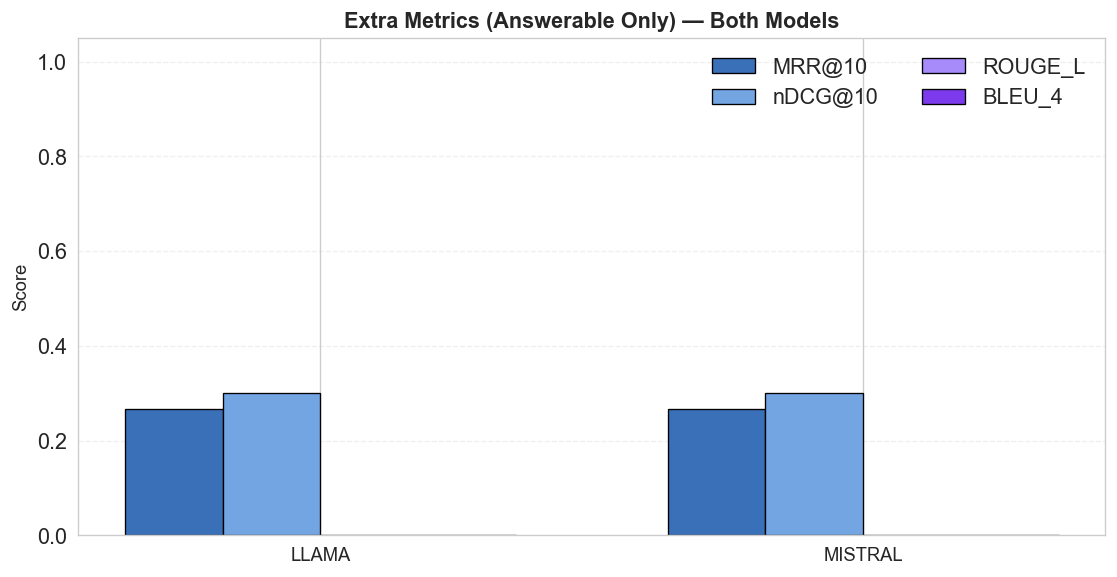

Saved → arabicaqa_rag_results/ragas_full\figures\extra_metrics_answerable_bar.png
Saved → arabicaqa_rag_results/ragas_full\figures\extra_metrics_answerable_bar.pdf


In [85]:
import os
import matplotlib.pyplot as plt
import numpy as np

# ======================
# PATH
# ======================
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ====== Theme colors ======
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

# ======================
# DATA
# ======================
df_plot = extra_df.sort_values("model").copy()
models = df_plot["model"].tolist()

# detect retrieval metric column names dynamically
mrr_col  = [c for c in df_plot.columns if c.lower().startswith("mrr@")][0]
ndcg_col = [c for c in df_plot.columns if c.lower().startswith("ndcg@")][0]

metrics = [
    (mrr_col,  df_plot[mrr_col].astype(float).tolist(),  PRIMARY),
    (ndcg_col, df_plot[ndcg_col].astype(float).tolist(), SECONDARY),
    ("ROUGE_L", df_plot["ROUGE_L"].astype(float).tolist(), ACCENT1),
    ("BLEU_4",  df_plot["BLEU_4"].astype(float).tolist(), ACCENT2),
]

# ======================
# PLOT
# ======================
x = np.arange(len(models))
w = 0.18
offsets = [-1.5*w, -0.5*w, 0.5*w, 1.5*w]

fig, ax = plt.subplots(figsize=(9.5, 5))

for i, (name, vals, color) in enumerate(metrics):
    ax.bar(
        x + offsets[i],
        vals,
        w,
        label=name,
        color=color,
        edgecolor="black",
        linewidth=0.8
    )

ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.set_ylabel("Score")
ax.set_title("Extra Metrics (Answerable Only) — Both Models", weight="bold")
ax.set_ylim(0, 1.05)

ax.legend(frameon=False, ncol=2)
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()

# ======================
# SAVE
# ======================
png_path = os.path.join(FIG_DIR, "extra_metrics_answerable_bar.png")
pdf_path = os.path.join(FIG_DIR, "extra_metrics_answerable_bar.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()

print(f"Saved → {png_path}")
print(f"Saved → {pdf_path}")
